<a href="https://colab.research.google.com/github/prabutlv/Projects-/blob/main/AdEase_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pmdarima prophet statsmodels scikit-learn matplotlib seaborn joblib


In [7]:
import os, gc, math, warnings
warnings.filterwarnings("ignore")

import polars as pl
import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_absolute_error as mae,
    mean_squared_error as mse,
    mean_absolute_percentage_error as mape
)


from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

'''# evaluation
def mape(a, f):
    a = np.array(a); f = np.array(f)
    mask = a != 0
    if mask.sum()==0:
        return np.nan
    return np.mean(np.abs((a[mask]-f[mask]) / a[mask]))*100'''


'# evaluation\ndef mape(a, f):\n    a = np.array(a); f = np.array(f)\n    mask = a != 0\n    if mask.sum()==0:\n        return np.nan\n    return np.mean(np.abs((a[mask]-f[mask]) / a[mask]))*100'

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
!gdown 1-2Z_qEP6vnRyWTOHgLQ6v_w9eWCQbwkz
!gdow 1uWrrobt_Izydgq7EK20wXtY8D-V0nYDc

Downloading...
From (original): https://drive.google.com/uc?id=1-2Z_qEP6vnRyWTOHgLQ6v_w9eWCQbwkz
From (redirected): https://drive.google.com/uc?id=1-2Z_qEP6vnRyWTOHgLQ6v_w9eWCQbwkz&confirm=t&uuid=05c26bc7-c496-4d2e-b3b3-6fc91d570f31
To: /content/Copy of train_1.csv
100% 278M/278M [00:03<00:00, 83.6MB/s]
/bin/bash: line 1: gdow: command not found


In [10]:
'''with open("Copy of train_1.csv", "r", encoding="utf-8") as f:
    header = f.readline().strip()
cols = header.split(",")
len(cols), cols[:10]'''


(551,
 ['"Page"',
  '"2015-07-01"',
  '"2015-07-02"',
  '"2015-07-03"',
  '"2015-07-04"',
  '"2015-07-05"',
  '"2015-07-06"',
  '"2015-07-07"',
  '"2015-07-08"',
  '"2015-07-09"'])

In [47]:
import csv

with open("Copy of train_1.csv", "r", encoding="utf-8") as f:
    reader = csv.reader(f)
    cols = next(reader)

len(cols), cols[:10]


(551,
 ['Page',
  '2015-07-01',
  '2015-07-02',
  '2015-07-03',
  '2015-07-04',
  '2015-07-05',
  '2015-07-06',
  '2015-07-07',
  '2015-07-08',
  '2015-07-09'])

In [48]:
schema = {col: pl.Utf8 for col in cols}


In [49]:
train = pl.read_csv(
    "/content/Copy of train_1.csv",
    schema_overrides=schema,
    ignore_errors=True,
    low_memory=True
)
print(train.shape)
# check first cols
print(train.columns[:10])


(145063, 551)
['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09']


In [51]:
train.head()

shape: (5, 551)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Page      ┆ 2015-07-0 ┆ 2015-07-0 ┆ 2015-07-0 ┆ … ┆ 2016-12-2 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12- │
│ ---       ┆ 1         ┆ 2         ┆ 3         ┆   ┆ 8         ┆ 9         ┆ 0         ┆ 31       │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ str       ┆ str       ┆ str       ┆   ┆ str       ┆ str       ┆ str       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2NE1_zh.w ┆ 18        ┆ 11        ┆ 5         ┆ … ┆ 22        ┆ 19        ┆ 18        ┆ 20       │
│ ikipedia. ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ org_all-a ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ cce…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2PM_zh.wi ┆ 11        ┆ 14        ┆ 15        ┆ … ┆ 52        ┆ 45        ┆ 26        ┆ 20       │
│ kipedia.o ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ rg_all-ac ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ces…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3C_zh.wik ┆ 1         ┆ 0         ┆ 1         ┆ … ┆ 6         ┆ 3         ┆ 4         ┆ 17       │
│ ipedia.or ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ g_all-acc ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ess…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 4minute_z ┆ 35        ┆ 13        ┆ 10        ┆ … ┆ 17        ┆ 19        ┆ 10        ┆ 11       │
│ h.wikiped ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ia.org_al ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ l-a…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 52_Hz_I_L ┆ null      ┆ null      ┆ null      ┆ … ┆ 27        ┆ 13        ┆ 36        ┆ 10       │
│ ove_You_z ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ h.wikiped ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ia.…      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [15]:
exog = pd.read_csv('/content/drive/MyDrive/Copy of Exog_Campaign_eng')
print(exog.shape)
c.head()

(550, 1)


Exog
0     0
1     0
2     0
3     0
4     0

In [33]:
train.schema

Schema([('title', String),
        ('language', String),
        ('access_type', String),
        ('access_origin', String),
        ('page', String),
        ('2015-07-01', String),
        ('2015-07-02', String),
        ('2015-07-03', String),
        ('2015-07-04', String),
        ('2015-07-05', String),
        ('2015-07-06', String),
        ('2015-07-07', String),
        ('2015-07-08', String),
        ('2015-07-09', String),
        ('2015-07-10', String),
        ('2015-07-11', String),
        ('2015-07-12', String),
        ('2015-07-13', String),
        ('2015-07-14', String),
        ('2015-07-15', String),
        ('2015-07-16', String),
        ('2015-07-17', String),
        ('2015-07-18', String),
        ('2015-07-19', String),
        ('2015-07-20', String),
        ('2015-07-21', String),
        ('2015-07-22', String),
        ('2015-07-23', String),
        ('2015-07-24', String),
        ('2015-07-25', String),
        ('2015-07-26', String),
        ('2015-07

In [35]:
train.dtypes

[String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 

In [36]:
train.null_count()

shape: (1, 555)
┌───────┬──────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ title ┆ language ┆ access_typ ┆ access_ori ┆ … ┆ 2016-12-28 ┆ 2016-12-29 ┆ 2016-12-3 ┆ 2016-12-3 │
│ ---   ┆ ---      ┆ e          ┆ gin        ┆   ┆ ---        ┆ ---        ┆ 0         ┆ 1         │
│ u32   ┆ u32      ┆ ---        ┆ ---        ┆   ┆ u32        ┆ u32        ┆ ---       ┆ ---       │
│       ┆          ┆ u32        ┆ u32        ┆   ┆            ┆            ┆ u32       ┆ u32       │
╞═══════╪══════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0     ┆ 95895    ┆ 0          ┆ 0          ┆ … ┆ 3822       ┆ 3826       ┆ 3635      ┆ 3465      │
└───────┴──────────┴────────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [45]:
train.null_count().select((pl.all()/train.height * 100).round(2))

shape: (1, 555)
┌───────┬──────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ title ┆ language ┆ access_typ ┆ access_ori ┆ … ┆ 2016-12-28 ┆ 2016-12-29 ┆ 2016-12-3 ┆ 2016-12-3 │
│ ---   ┆ ---      ┆ e          ┆ gin        ┆   ┆ ---        ┆ ---        ┆ 0         ┆ 1         │
│ f64   ┆ f64      ┆ ---        ┆ ---        ┆   ┆ f64        ┆ f64        ┆ ---       ┆ ---       │
│       ┆          ┆ f64        ┆ f64        ┆   ┆            ┆            ┆ f64       ┆ f64       │
╞═══════╪══════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0.0   ┆ 66.11    ┆ 0.0        ┆ 0.0        ┆ … ┆ 2.63       ┆ 2.64       ┆ 2.51      ┆ 2.39      │
└───────┴──────────┴────────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [32]:
train.describe()


shape: (9, 556)
┌───────────┬───────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic ┆ title     ┆ language ┆ access_ty ┆ … ┆ 2016-12-2 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12-3 │
│ ---       ┆ ---       ┆ ---      ┆ pe        ┆   ┆ 8         ┆ 9         ┆ 0         ┆ 1         │
│ str       ┆ str       ┆ str      ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│           ┆           ┆          ┆ str       ┆   ┆ str       ┆ str       ┆ str       ┆ str       │
╞═══════════╪═══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count     ┆ 145063    ┆ 49168    ┆ 145063    ┆ … ┆ 141241    ┆ 141237    ┆ 141428    ┆ 141598    │
│ null_coun ┆ 0         ┆ 95895    ┆ 0         ┆ … ┆ 3822      ┆ 3826      ┆ 3635      ┆ 3465      │
│ t         ┆           ┆          ┆           ┆   ┆           ┆           ┆           ┆           │
│ mean      ┆ null      ┆ null     ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ std       ┆ null      ┆ null     ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ min       ┆ !vote     ┆ de       ┆ !         ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
│ 25%       ┆ null      ┆ null     ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 50%       ┆ null      ┆ null     ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 75%       ┆ null      ┆ null     ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ max       ┆ ［Alexand ┆ zh       ┆ －第四次  ┆ … ┆ 9996      ┆ 9996      ┆ 9996      ┆ 999       │
│           ┆ ros］     ┆          ┆ 元－      ┆   ┆           ┆           ┆           ┆           │
└───────────┴───────────┴──────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [37]:
exog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Exog    550 non-null    int64
dtypes: int64(1)
memory usage: 4.4 KB


In [38]:
exog.describe()

Exog
count  550.000000
mean     0.098182
std      0.297831
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000

In [39]:
exog.isna().sum()

Exog    0
dtype: int64

In [52]:
page_col = train.columns[0]
train = train.rename({page_col: "page"})
print("page column:", train.columns[0])


page column: page


#Parse page into (title, language, access_type, access_origin) — do this in pandas for flexibility

In [53]:
def parse_page_name(s):
    # robust parser: fallback to None if missing pieces
    try:
        parts = s.split("_")
        title = parts[0] if len(parts)>0 else None
        lang_dom = parts[1] if len(parts)>1 else None
        access_type = parts[2] if len(parts)>2 else None
        access_origin = parts[3] if len(parts)>3 else None

        language = None
        if lang_dom and ".wikipedia" in lang_dom:
            language = lang_dom.split(".")[0]  # 'en', 'zh', etc.

        return title, language, access_type, access_origin
    except Exception:
        return None, None, None, None

# Convert only page column to pandas, parse, then attach back
page_series = train["page"].to_pandas()
parsed = page_series.apply(lambda x: pd.Series(parse_page_name(x),
                                               index=["title","language","access_type","access_origin"]))
# convert parsed to polars and horizontally concatenate
parsed_pl = pl.from_pandas(parsed)
train = parsed_pl.hstack(train)   # parsed columns come first
print(train.columns[:10])


['title', 'language', 'access_type', 'access_origin', 'page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05']


In [54]:
train.head()

shape: (5, 555)
┌─────────┬──────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ title   ┆ language ┆ access_typ ┆ access_ori ┆ … ┆ 2016-12-2 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12-3 │
│ ---     ┆ ---      ┆ e          ┆ gin        ┆   ┆ 8         ┆ 9         ┆ 0         ┆ 1         │
│ str     ┆ str      ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆          ┆ str        ┆ str        ┆   ┆ str       ┆ str       ┆ str       ┆ str       │
╞═════════╪══════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2NE1    ┆ zh       ┆ all-access ┆ spider     ┆ … ┆ 22        ┆ 19        ┆ 18        ┆ 20        │
│ 2PM     ┆ zh       ┆ all-access ┆ spider     ┆ … ┆ 52        ┆ 45        ┆ 26        ┆ 20        │
│ 3C      ┆ zh       ┆ all-access ┆ spider     ┆ … ┆ 6         ┆ 3         ┆ 4         ┆ 17        │
│ 4minute ┆ zh       ┆ all-access ┆ spider     ┆ … ┆ 17        ┆ 19        ┆ 10        ┆ 11        │
│ 52      ┆ null     ┆ I          ┆ Love       ┆ … ┆ 27        ┆ 13        ┆ 36        ┆ 10        │
└─────────┴──────────┴────────────┴────────────┴───┴───────────┴───────────┴───────────┴───────────┘

#Identify date columns

In [55]:
date_cols = [c for c in train.columns if c.startswith('20')]
print(f"Found {len(date_cols)} date columns. Start: {date_cols[:3]}, End: {date_cols[-3:]}")


Found 550 date columns. Start: ['2015-07-01', '2015-07-02', '2015-07-03'], End: ['2016-12-29', '2016-12-30', '2016-12-31']


#Chunked melt (Polars) — memory safe: write each chunk to parquet (or process per chunk)

In [56]:
OUT_DIR = "/content/tmp_melt_chunks"
os.makedirs(OUT_DIR, exist_ok=True)

chunk_pages = 10000   # tune this (5k is safe for Colab)
n_rows = train.shape[0]
chunks = math.ceil(n_rows / chunk_pages)
print("Total rows:", n_rows, "Chunks:", chunks)

for i in range(0, n_rows, chunk_pages):
    chunk = train.slice(i, chunk_pages)  # polars slice
    # unpivot (Polars uses `melt` alias `unpivot`)
    melted = chunk.melt(
        id_vars=['page','title','language','access_type','access_origin'],
        value_vars=date_cols,
        variable_name="date",
        value_name="views"
    )
    # cast types: date -> utf8 now; views -> float
    melted = melted.with_columns([
        pl.col("date").str.replace_all('"', ''),
        pl.col("views").cast(pl.Float64, strict=False)
    ])
    out_fn = os.path.join(OUT_DIR, f"melt_{i}.parquet")
    melted.write_parquet(out_fn)
    print(f"Written {out_fn} shape: {melted.shape}")
    del chunk, melted
    gc.collect()


Total rows: 145063 Chunks: 15
Written /content/tmp_melt_chunks/melt_0.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_10000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_20000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_30000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_40000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_50000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_60000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_70000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_80000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_90000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_100000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_110000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/melt_120000.parquet shape: (5500000, 7)
Written /content/tmp_melt_chunks/me

In [21]:
sample = pl.read_parquet("/content/tmp_melt_chunks/melt_0.parquet")
sample.head()

shape: (5, 7)
┌──────────────────────────┬─────────┬──────────┬─────────────┬───────────────┬────────────┬───────┐
│ page                     ┆ title   ┆ language ┆ access_type ┆ access_origin ┆ date       ┆ views │
│ ---                      ┆ ---     ┆ ---      ┆ ---         ┆ ---           ┆ ---        ┆ ---   │
│ str                      ┆ str     ┆ str      ┆ str         ┆ str           ┆ str        ┆ f64   │
╞══════════════════════════╪═════════╪══════════╪═════════════╪═══════════════╪════════════╪═══════╡
│ 2NE1_zh.wikipedia.org_al ┆ 2NE1    ┆ zh       ┆ all-access  ┆ spider        ┆ 2015-07-01 ┆ 18.0  │
│ l-acce…                  ┆         ┆          ┆             ┆               ┆            ┆       │
│ 2PM_zh.wikipedia.org_all ┆ 2PM     ┆ zh       ┆ all-access  ┆ spider        ┆ 2015-07-01 ┆ 11.0  │
│ -acces…                  ┆         ┆          ┆             ┆               ┆            ┆       │
│ 3C_zh.wikipedia.org_all- ┆ 3C      ┆ zh       ┆ all-access  ┆ spider        ┆ 2015-07-01 ┆ 1.0   │
│ access…                  ┆         ┆          ┆             ┆               ┆            ┆       │
│ 4minute_zh.wikipedia.org ┆ 4minute ┆ zh       ┆ all-access  ┆ spider        ┆ 2015-07-01 ┆ 35.0  │
│ _all-a…                  ┆         ┆          ┆             ┆               ┆            ┆       │
│ 52_Hz_I_Love_You_zh.wiki ┆ 52      ┆ null     ┆ I           ┆ Love          ┆ 2015-07-01 ┆ null  │
│ pedia.…                  ┆         ┆          ┆             ┆               ┆            ┆       │
└──────────────────────────┴─────────┴──────────┴─────────────┴───────────────┴────────────┴───────┘

In [22]:
sample.sample(10)

shape: (10, 7)
┌───────────────────┬──────────┬──────────┬──────────────────┬───────────────┬────────────┬────────┐
│ page              ┆ title    ┆ language ┆ access_type      ┆ access_origin ┆ date       ┆ views  │
│ ---               ┆ ---      ┆ ---      ┆ ---              ┆ ---           ┆ ---        ┆ ---    │
│ str               ┆ str      ┆ str      ┆ str              ┆ str           ┆ str        ┆ f64    │
╞═══════════════════╪══════════╪══════════╪══════════════════╪═══════════════╪════════════╪════════╡
│ Fratelli_d’Italia ┆ Fratelli ┆ null     ┆ fr.wikipedia.org ┆ desktop       ┆ 2016-04-19 ┆ 63.0   │
│ _fr.wikipedia…    ┆          ┆          ┆                  ┆               ┆            ┆        │
│ 葉問2_zh.wikipedi ┆ 葉問2    ┆ zh       ┆ all-access       ┆ spider        ┆ 2015-10-01 ┆ 6.0    │
│ a.org_all-acces…  ┆          ┆          ┆                  ┆               ┆            ┆        │
│ Henri_Rousseau_fr ┆ Henri    ┆ null     ┆ fr.wikipedia.org ┆ desktop       ┆ 2016-01-18 ┆ 370.0  │
│ .wikipedia.or…    ┆          ┆          ┆                  ┆               ┆            ┆        │
│ Saison_6_de_Prett ┆ Saison   ┆ null     ┆ de               ┆ Pretty        ┆ 2016-04-05 ┆ 945.0  │
│ y_Little_Liar…    ┆          ┆          ┆                  ┆               ┆            ┆        │
│ J._Cole_en.wikipe ┆ J.       ┆ null     ┆ en.wikipedia.org ┆ desktop       ┆ 2016-09-30 ┆ 1580.0 │
│ dia.org_deskt…    ┆          ┆          ┆                  ┆               ┆            ┆        │
│ 流浪神差_zh.wikip ┆ 流浪神差 ┆ zh       ┆ all-access       ┆ spider        ┆ 2016-02-19 ┆ 15.0   │
│ edia.org_all-acce ┆          ┆          ┆                  ┆               ┆            ┆        │
│ …                 ┆          ┆          ┆                  ┆               ┆            ┆        │
│ Saison_7_de_Vampi ┆ Saison   ┆ null     ┆ de               ┆ Vampire       ┆ 2016-06-30 ┆ 583.0  │
│ re_Diaries_fr…    ┆          ┆          ┆                  ┆               ┆            ┆        │
│ List_of_countries ┆ List     ┆ null     ┆ countries        ┆ by            ┆ 2016-04-30 ┆ 1523.0 │
│ _by_intention…    ┆          ┆          ┆                  ┆               ┆            ┆        │
│ 星野飛鳥_zh.wikip ┆ 星野飛鳥 ┆ zh       ┆ all-access       ┆ spider        ┆ 2016-06-16 ┆ 3.0    │
│ edia.org_all-acce ┆          ┆          ┆                  ┆               ┆            ┆        │
│ …                 ┆          ┆          ┆                  ┆               ┆            ┆        │
│ Montréal_fr.wikip ┆ Montréal ┆ fr       ┆ desktop          ┆ all-agents    ┆ 2016-06-18 ┆ 1185.0 │
│ edia.org_desk…    ┆          ┆          ┆                  ┆               ┆            ┆        │
└───────────────────┴──────────┴──────────┴──────────────────┴───────────────┴────────────┴────────┘

#Load melted parquet in manageable partitions (or merge if you have memory)

In [23]:
import glob
parquet_files = sorted(glob.glob(OUT_DIR+"/*.parquet"))
# Example: load only English pages to pandas
dfs = []
for p in parquet_files:
    dfp = pl.read_parquet(p)
    # filter english rows in Polars (fast) before converting to pandas
    en = dfp.filter(pl.col("language") == "en")
    if en.height>0:
        dfs.append(en.to_pandas())
    del dfp, en
    gc.collect()

ts_en = pd.concat(dfs, ignore_index=True)
ts_en['date'] = pd.to_datetime(ts_en['date'])
#print(ts_en.head())
ts_en = ts_en.sort_values(['page','date'])
#print(ts_en.head())
print("English ts:", ts_en.shape)


English ts: (1330450, 7)


In [24]:
ts_en.head()

page  title  ...       date views
624719  !vote_en.wikipedia.org_all-access_all-agents  !vote  ... 2015-07-01   3.0
625438  !vote_en.wikipedia.org_all-access_all-agents  !vote  ... 2015-07-02   4.0
626157  !vote_en.wikipedia.org_all-access_all-agents  !vote  ... 2015-07-03   7.0
626876  !vote_en.wikipedia.org_all-access_all-agents  !vote  ... 2015-07-04   4.0
627595  !vote_en.wikipedia.org_all-access_all-agents  !vote  ... 2015-07-05   4.0

[5 rows x 7 columns]

#EDA (on a sample page or language-level)

<bound method NDFrame.head of page
Special:Search_en.wikipedia.org_all-access_all-agents                       1.304079e+09
Special:Search_en.wikipedia.org_desktop_all-agents                          1.011848e+09
Special:Search_en.wikipedia.org_mobile-web_all-agents                       2.921628e+08
Special:Book_en.wikipedia.org_all-access_all-agents                         1.339931e+08
Special:Book_en.wikipedia.org_desktop_all-agents                            1.332859e+08
                                                                                ...     
User:GoogleAnalitycsRoman2/google-api_en.wikipedia.org_all-access_spider    0.000000e+00
User:GoogleAnalitycsRoman5/google-api_en.wikipedia.org_all-access_spider    0.000000e+00
User:GoogleAnalitycsRoman6/google-api_en.wikipedia.org_all-access_spider    0.000000e+00
Ajol_en.wikipedia.org_all-access_all-agents                                 0.000000e+00
SriValli_en.wikipedia.org_all-access_all-agents                            

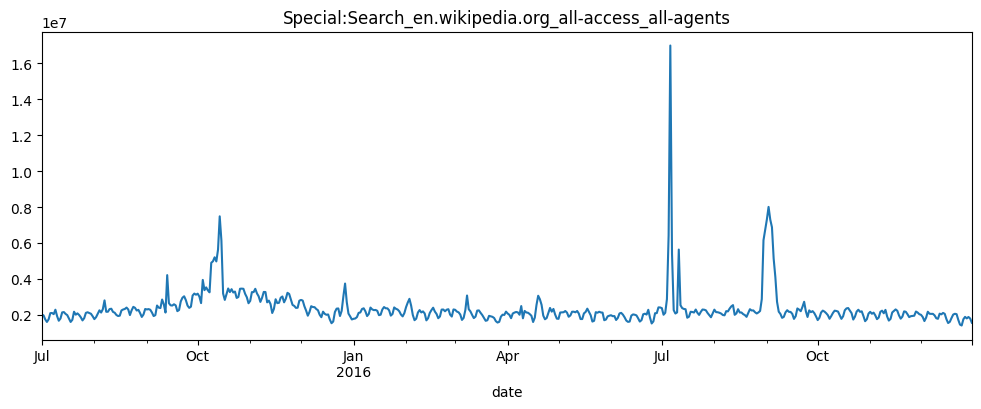

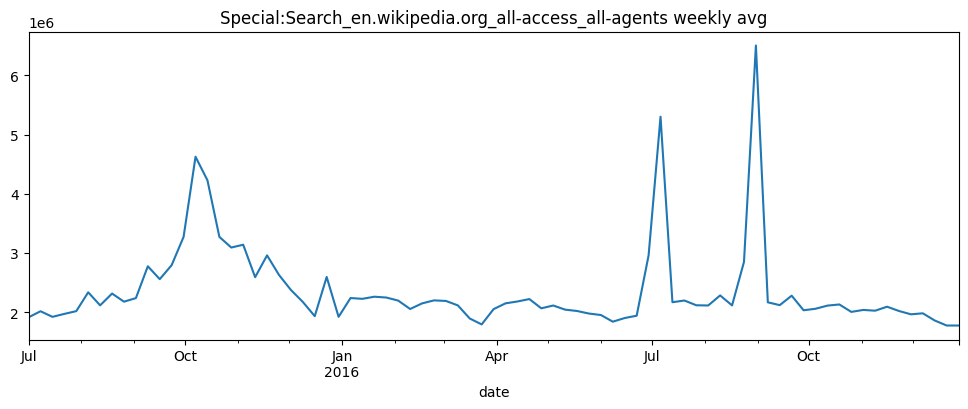

In [25]:
# sample pages by total views
agg = ts_en.groupby('page')['views'].sum().sort_values(ascending=False)
print(agg.head)
top_pages = agg.head(5).index.tolist()
print(top_pages)

# plot first top page
sample = top_pages[0]
s = ts_en[ts_en['page']==sample].set_index('date')['views'].sort_index()
s.plot(figsize=(12,4), title=sample)
plt.show()

# weekly seasonality detection (visual)
weekly = s.resample('7D').mean()
weekly.plot(figsize=(12,4), title=f"{sample} weekly avg")
plt.show()


In [57]:
import gc
from collections import defaultdict

# Collect parquet files
parquet_files = sorted(glob.glob(OUT_DIR + "/*.parquet"))

# Dictionary: language -> list of pandas dataframes
lang_dfs = defaultdict(list)

# Dictionary: language -> row count
lang_counts = defaultdict(int)

for p in parquet_files:
    dfp = pl.read_parquet(p)

    # Get unique languages in this chunk
    languages = dfp.select("language").unique().to_series().to_list()

    for lang in languages:
        df_lang = dfp.filter(pl.col("language") == lang)

        if df_lang.height > 0:
            lang_counts[lang] += df_lang.height
            lang_dfs[lang].append(df_lang.to_pandas())

    del dfp, df_lang
    gc.collect()

# Combine and sort each language dataframe
final_ts = {}

for lang, dfs in lang_dfs.items():
    ts = pd.concat(dfs, ignore_index=True)
    ts["date"] = pd.to_datetime(ts["date"])
    ts = ts.sort_values(["page", "date"])
    final_ts[lang] = ts

# Print summary
print("\n Language-wise row counts:")
for lang, cnt in sorted(lang_counts.items(), key=lambda x: -x[1]):
    print(f"Language: {lang:5s} | Rows: {cnt:,}")



 Language-wise row counts:
Language: ja    | Rows: 9,946,750
Language: zh    | Rows: 8,353,950
Language: de    | Rows: 2,492,600
Language: es    | Rows: 1,910,150
Language: ru    | Rows: 1,599,950
Language: fr    | Rows: 1,408,550
Language: en    | Rows: 1,330,450


In [27]:
final_ts.keys()

dict_keys(['en', 'fr', 'zh', 'ru', 'de', 'ja', 'es'])

In [61]:
overall_null_pct = {}

for lang, df in final_ts.items():
    total_cells = df.shape[0] * df.shape[1]
    total_nulls = df.isna().sum().sum()

    overall_null_pct[lang] = round((total_nulls / total_cells) * 100, 2)

overall_null_pct


{'en': np.float64(0.73),
 'fr': np.float64(0.19),
 'zh': np.float64(1.34),
 'ru': np.float64(0.19),
 'de': np.float64(0.34),
 'ja': np.float64(0.67),
 'es': np.float64(0.07)}

In [29]:
lang_dfs.items()

dict_items([('fr', [                                                     page              title  \
0                   @_fr.wikipedia.org_desktop_all-agents                  @   
1               AC/DC_fr.wikipedia.org_desktop_all-agents              AC/DC   
2               AR-15_fr.wikipedia.org_desktop_all-agents              AR-15   
3                Abat_fr.wikipedia.org_desktop_all-agents               Abat   
4             Achille_fr.wikipedia.org_desktop_all-agents            Achille   
...                                                   ...                ...   
367945         Hermès_fr.wikipedia.org_desktop_all-agents             Hermès   
367946  Spécial:Recherche_fr.wikipedia.org_desktop_all...  Spécial:Recherche   
367947  Saint-Étienne_fr.wikipedia.org_desktop_all-agents      Saint-Étienne   
367948          Néron_fr.wikipedia.org_desktop_all-agents              Néron   
367949        Orléans_fr.wikipedia.org_desktop_all-agents            Orléans   

       language acc

In [28]:
lang_dfs

defaultdict(list,
            {'fr': [                                                     page              title  \
              0                   @_fr.wikipedia.org_desktop_all-agents                  @   
              1               AC/DC_fr.wikipedia.org_desktop_all-agents              AC/DC   
              2               AR-15_fr.wikipedia.org_desktop_all-agents              AR-15   
              3                Abat_fr.wikipedia.org_desktop_all-agents               Abat   
              4             Achille_fr.wikipedia.org_desktop_all-agents            Achille   
              ...                                                   ...                ...   
              367945         Hermès_fr.wikipedia.org_desktop_all-agents             Hermès   
              367946  Spécial:Recherche_fr.wikipedia.org_desktop_all...  Spécial:Recherche   
              367947  Saint-Étienne_fr.wikipedia.org_desktop_all-agents      Saint-Étienne   
              367948          Néron_

In [26]:
final_ts['en']

page    title language  \
624719  !vote_en.wikipedia.org_all-access_all-agents    !vote       en   
625438  !vote_en.wikipedia.org_all-access_all-agents    !vote       en   
626157  !vote_en.wikipedia.org_all-access_all-agents    !vote       en   
626876  !vote_en.wikipedia.org_all-access_all-agents    !vote       en   
627595  !vote_en.wikipedia.org_all-access_all-agents    !vote       en   
...                                              ...      ...      ...   
302819   d-block_en.wikipedia.org_desktop_all-agents  d-block       en   
303217   d-block_en.wikipedia.org_desktop_all-agents  d-block       en   
303615   d-block_en.wikipedia.org_desktop_all-agents  d-block       en   
304013   d-block_en.wikipedia.org_desktop_all-agents  d-block       en   
304411   d-block_en.wikipedia.org_desktop_all-agents  d-block       en   

       access_type access_origin       date  views  
624719  all-access    all-agents 2015-07-01    3.0  
625438  all-access    all-agents 2015-07-02    4.0  
626157  all-access    all-agents 2015-07-03    7.0  
626876  all-access    all-agents 2015-07-04    4.0  
627595  all-access    all-agents 2015-07-05    4.0  
...            ...           ...        ...    ...  
302819     desktop    all-agents 2016-12-27    8.0  
303217     desktop    all-agents 2016-12-28    4.0  
303615     desktop    all-agents 2016-12-29    9.0  
304013     desktop    all-agents 2016-12-30    2.0  
304411     desktop    all-agents 2016-12-31    3.0  

[1330450 rows x 7 columns]

In [30]:
lang_dfs.keys()

dict_keys(['en', 'fr', 'zh', 'ru', 'de', 'ja', 'es'])

In [ ]:
#

In [58]:
#Analyze language top pages
def analyze_language_pages(
    lang: str,
    dfs: list[pd.DataFrame],
    top_n: int = 5,
    freq: str = "7D",
    plot: bool = True,
):
    """
    Analyze top pages for a single language:
    - Aggregate views
    - Plot daily trend
    - Plot weekly seasonality

    Memory-efficient: processes only ONE language at a time.
    """

    print(f"\n===== Language: {lang} =====")

    # Concatenate only this language
    ts = pd.concat(dfs, ignore_index=True)[['page', 'date', 'views']]
    ts['date'] = pd.to_datetime(ts['date'])

    # Top pages by total views
    agg = (
        ts.groupby('page')['views']
        .sum()
        .sort_values(ascending=False)
    )

    top_pages = agg.head(top_n).index.tolist()
    print("Top pages:", top_pages)

    # Process ONE page at a time
    for page in top_pages:
        s = (
            ts[ts['page'] == page]
            .set_index('date')['views']
            .sort_index()
        )

        if plot:
            # Daily
            s.plot(figsize=(12,4), title=f"{lang} | {page} daily")
            plt.show()

            # Weekly seasonality
            weekly = s.resample(freq).mean()
            weekly.plot(figsize=(12,4), title=f"{lang} | {page} weekly avg")
            plt.show()

    # Explicit cleanup (safe for large data)
    del ts



===== Language: en =====
Top pages: ['Special:Search_en.wikipedia.org_all-access_all-agents', 'Special:Search_en.wikipedia.org_desktop_all-agents', 'Special:Search_en.wikipedia.org_mobile-web_all-agents', 'Special:Book_en.wikipedia.org_all-access_all-agents', 'Special:Book_en.wikipedia.org_desktop_all-agents']


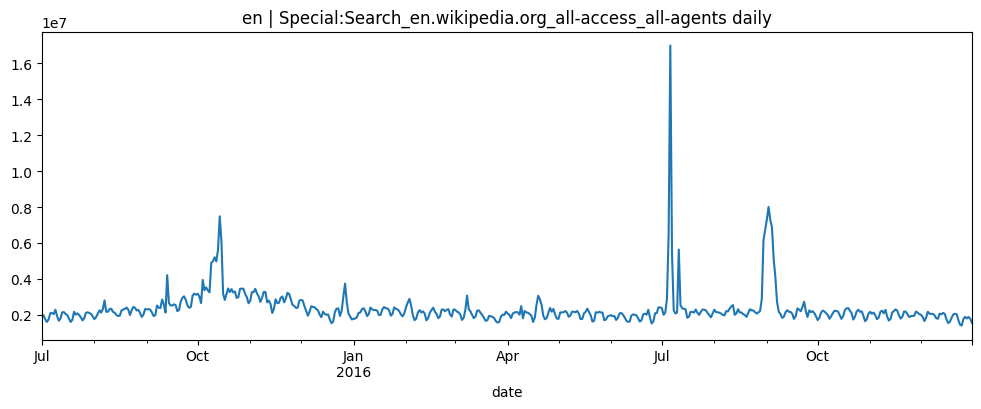

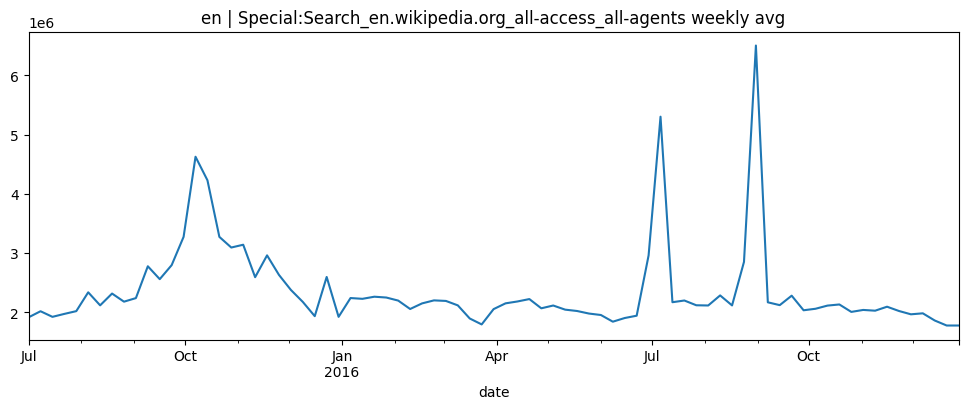

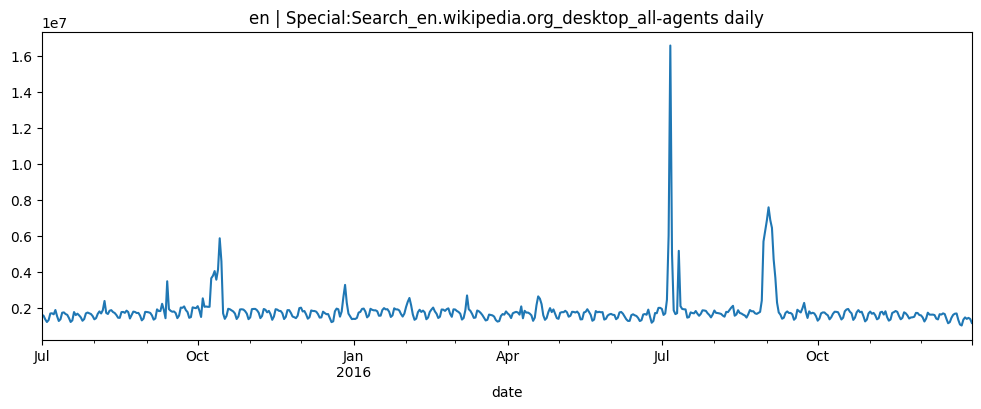

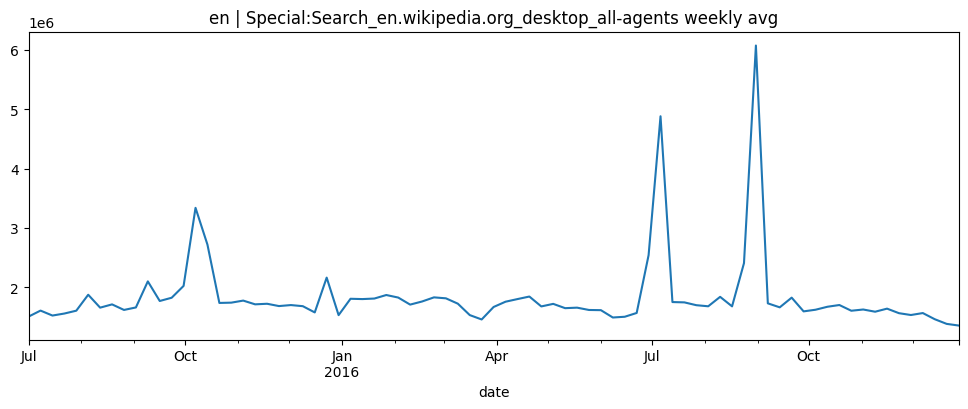

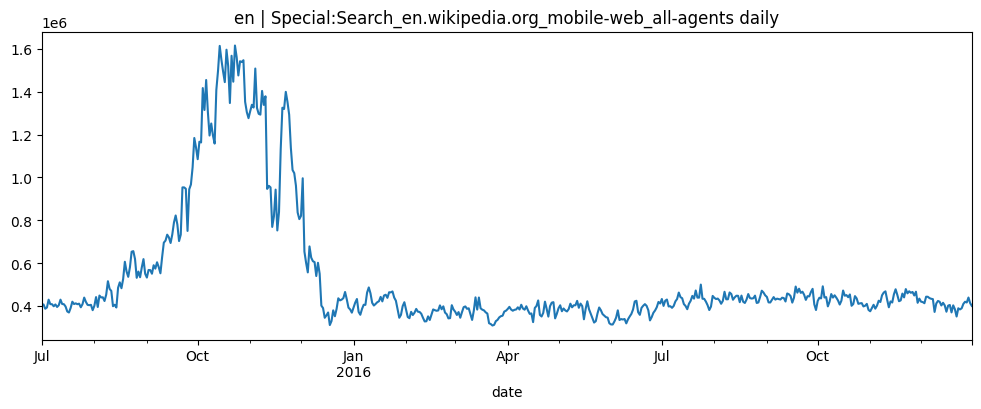

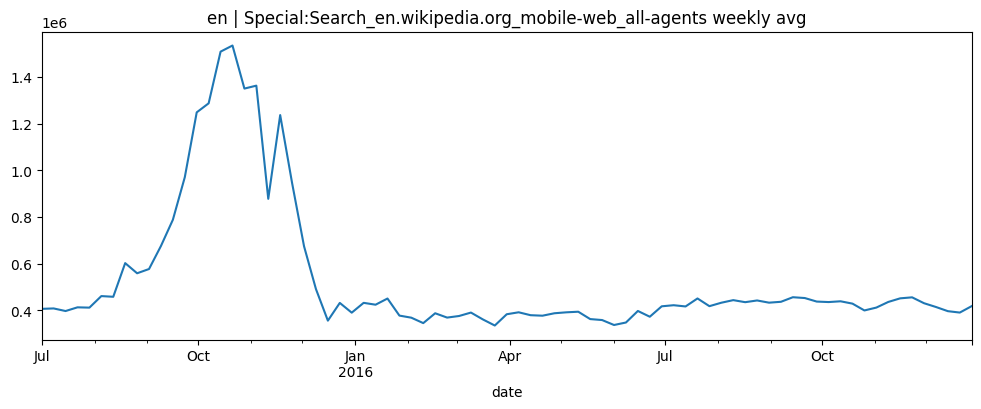

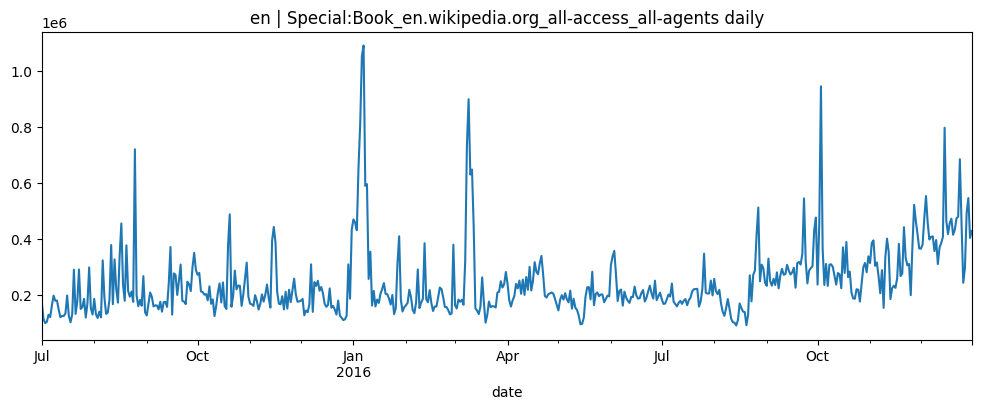

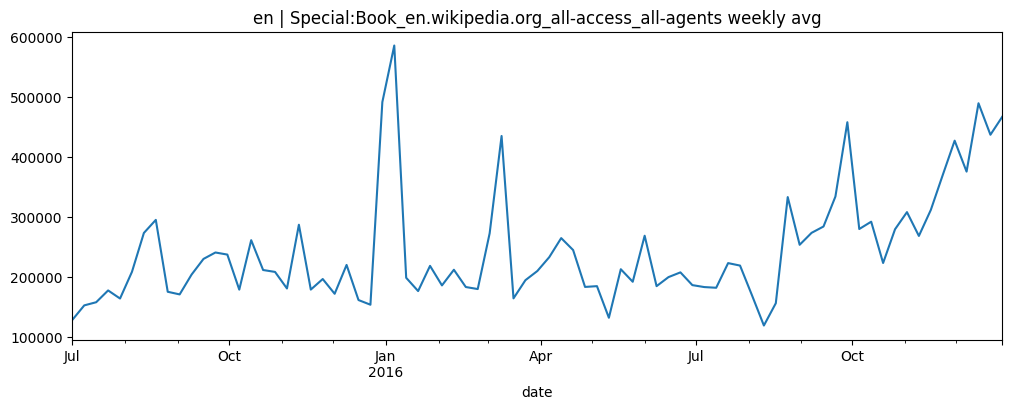

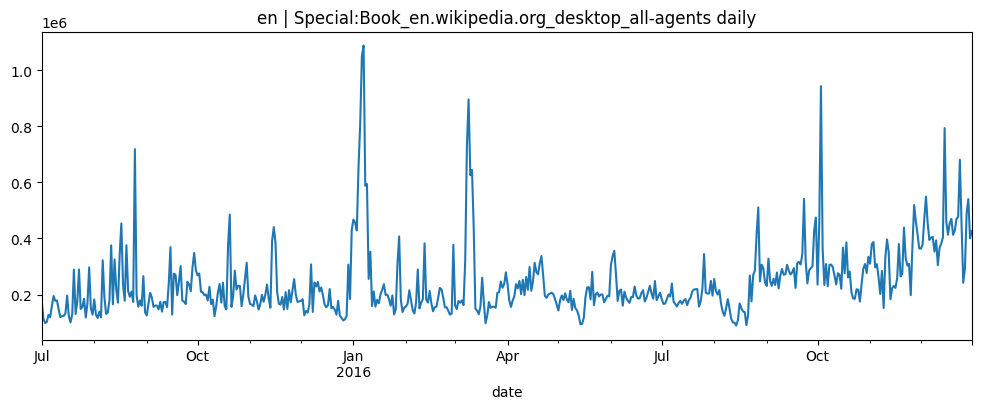

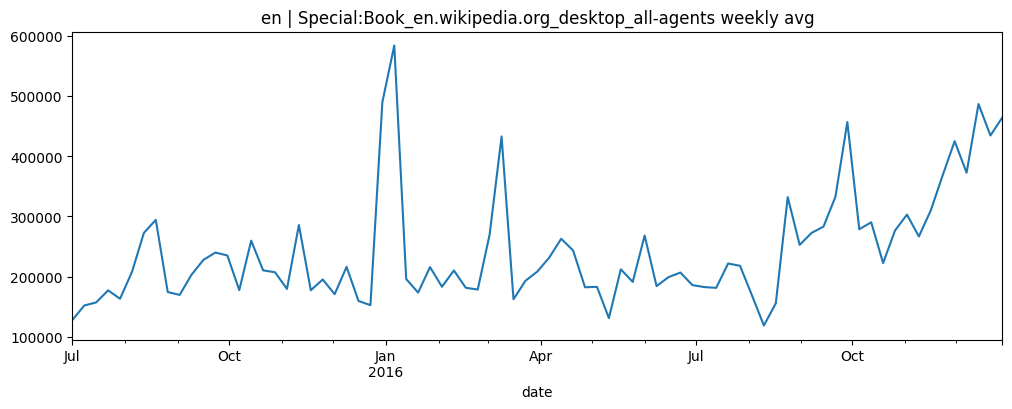


===== Language: fr =====
Top pages: ['Spécial:Recherche_fr.wikipedia.org_all-access_all-agents', 'Spécial:Recherche_fr.wikipedia.org_desktop_all-agents', 'Sp?cial:Search_fr.wikipedia.org_all-access_all-agents', 'Sp?cial:Search_fr.wikipedia.org_desktop_all-agents', 'Spécial:Connexion_fr.wikipedia.org_all-access_all-agents']


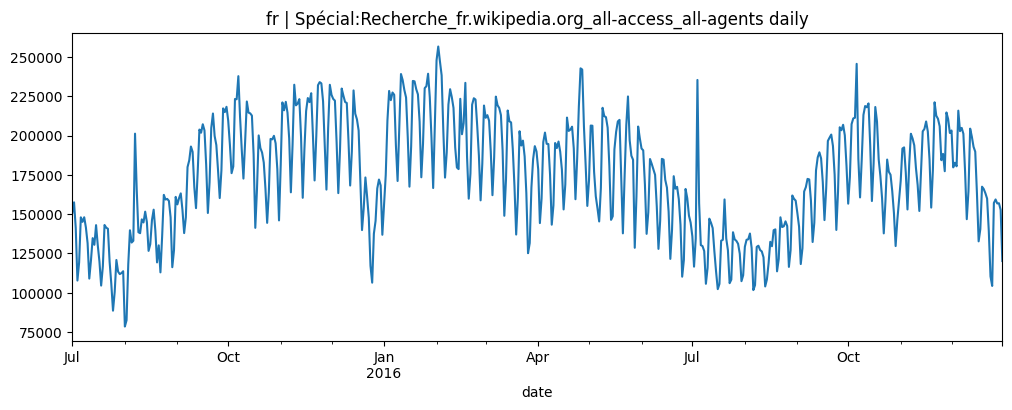

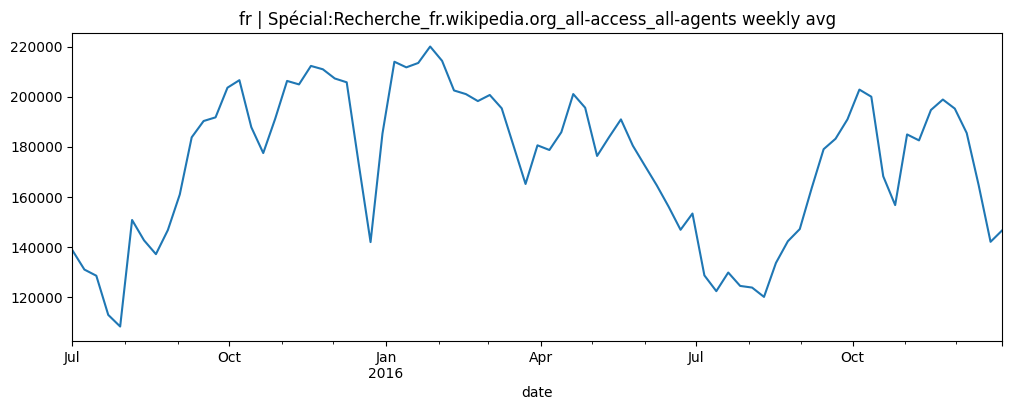

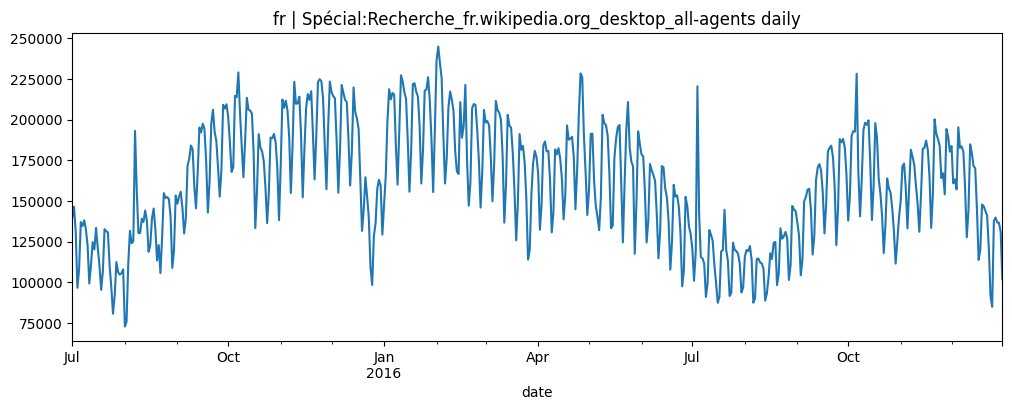

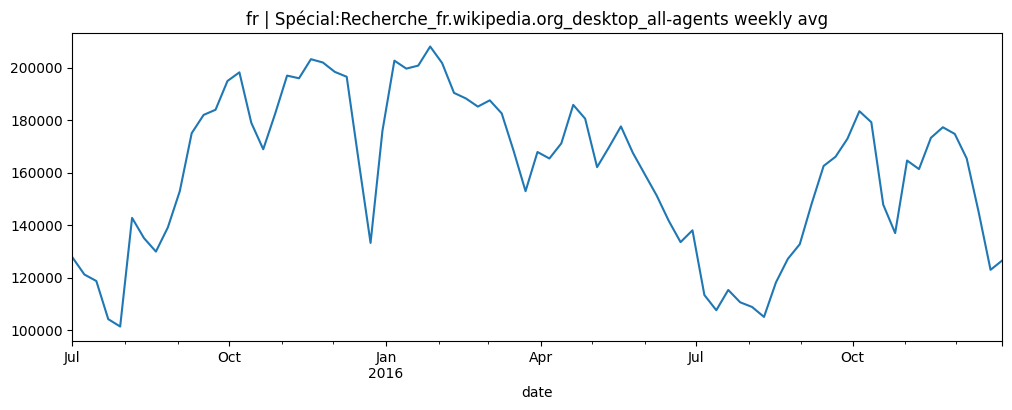

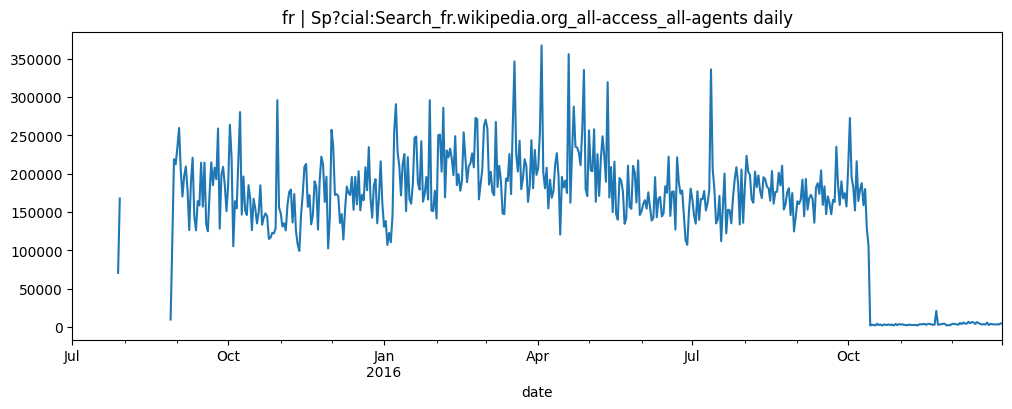

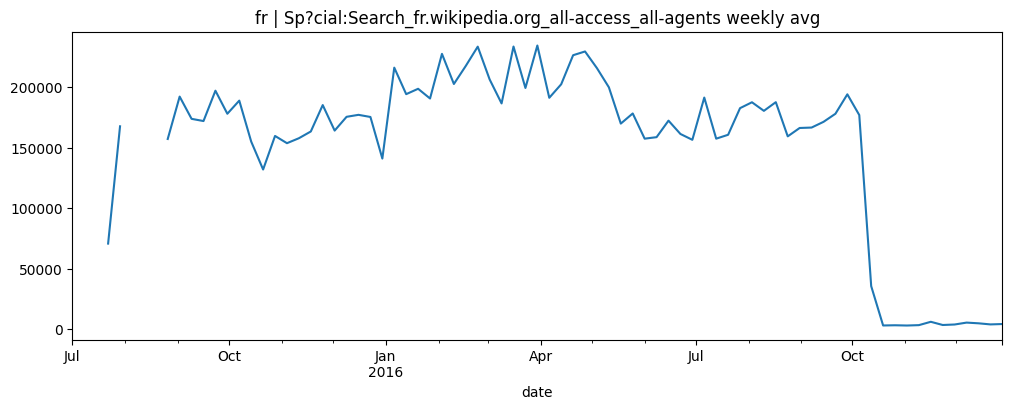

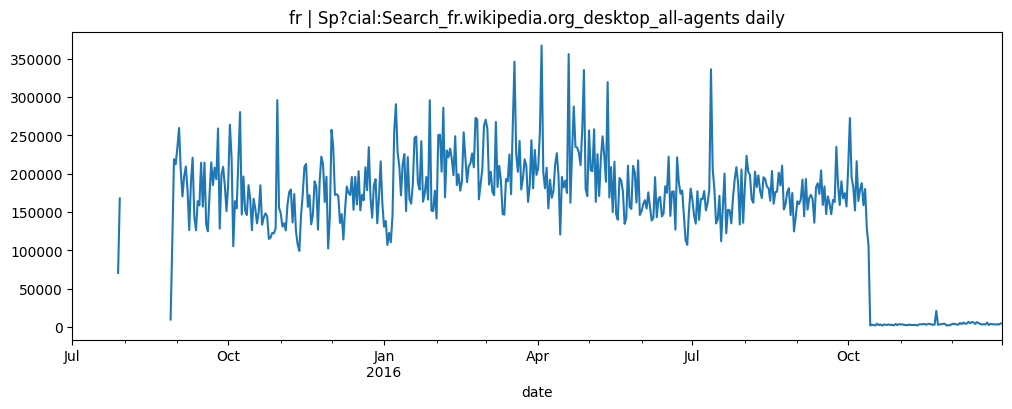

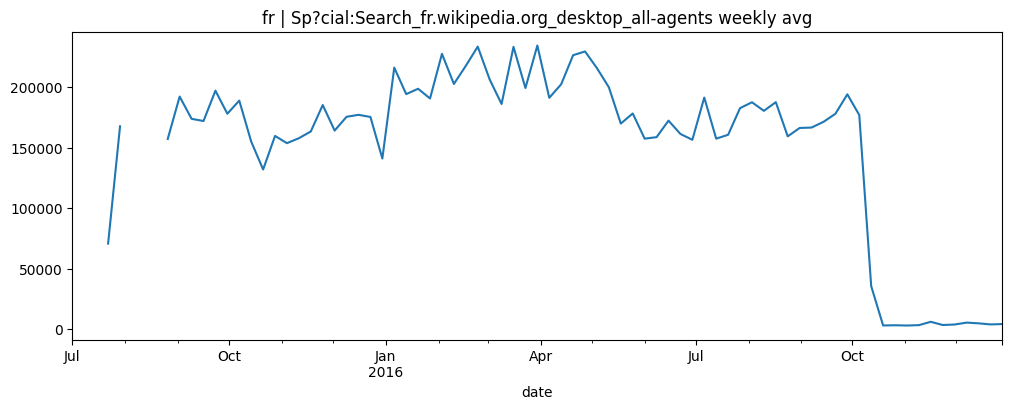

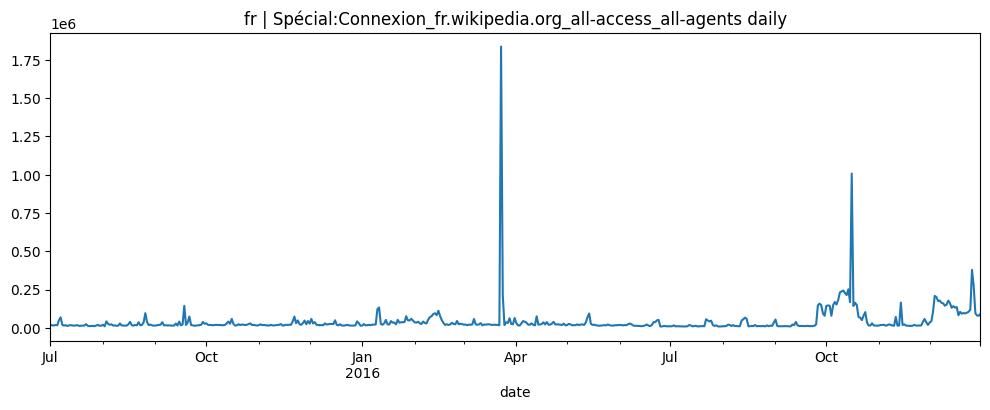

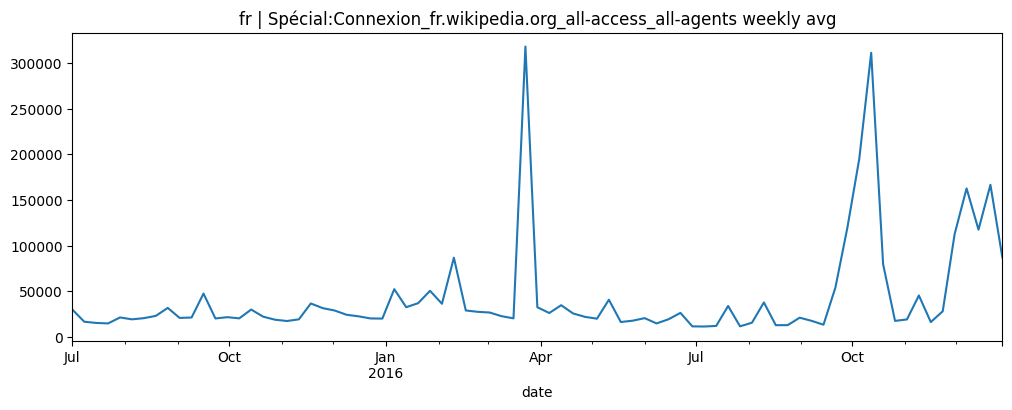


===== Language: zh =====
Top pages: ['Wikipedia:首页_zh.wikipedia.org_all-access_all-agents', 'Wikipedia:首页_zh.wikipedia.org_desktop_all-agents', 'Wikipedia:首页_zh.wikipedia.org_mobile-web_all-agents', 'Special:搜索_zh.wikipedia.org_all-access_all-agents', 'Special:搜索_zh.wikipedia.org_desktop_all-agents']


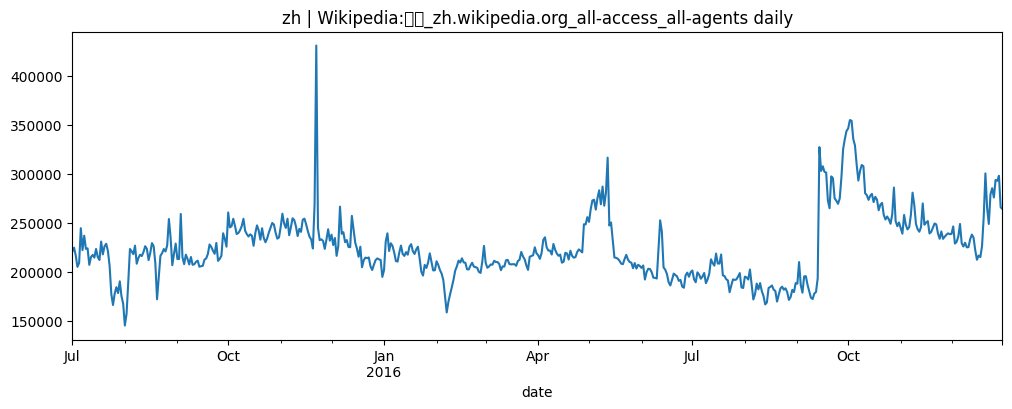

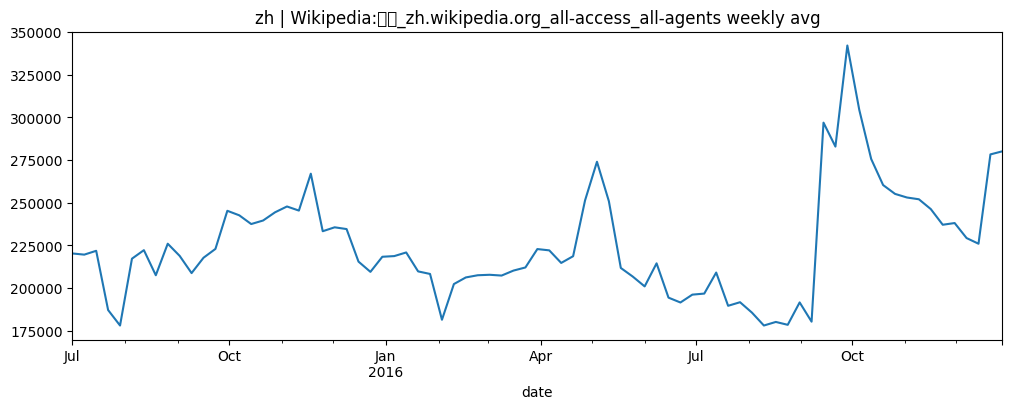

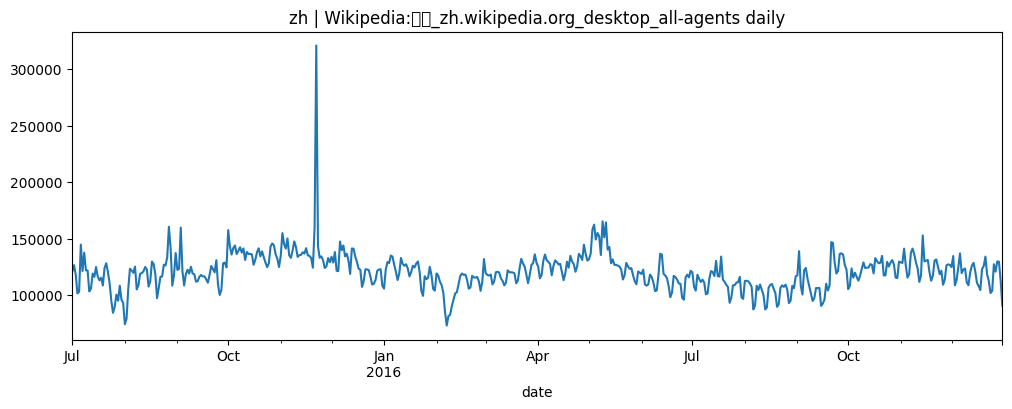

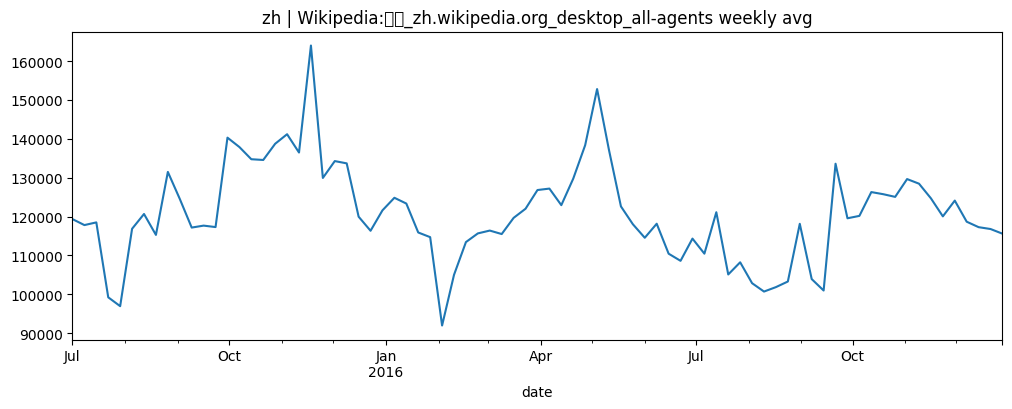

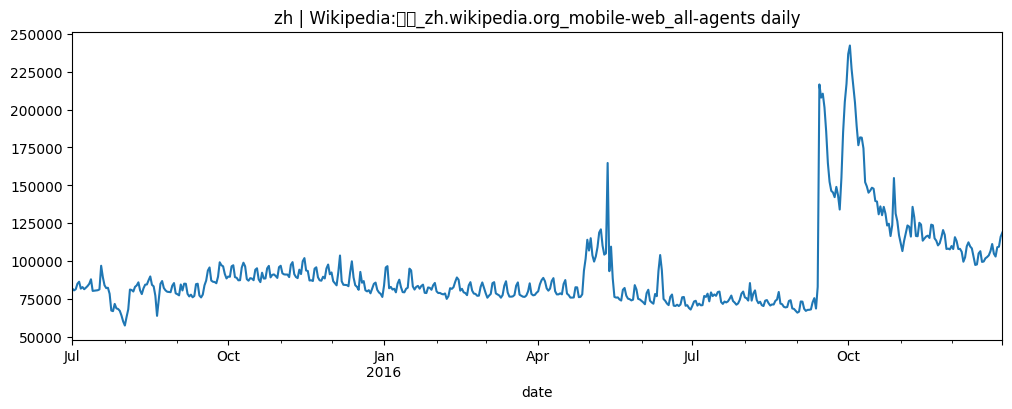

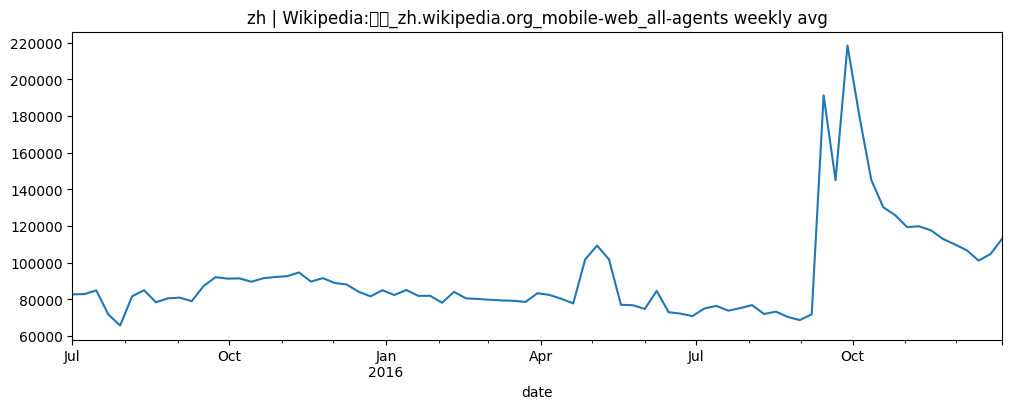

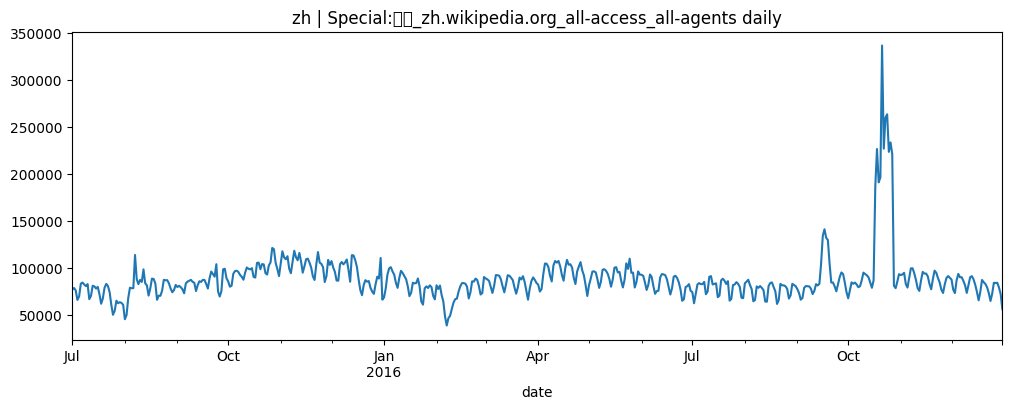

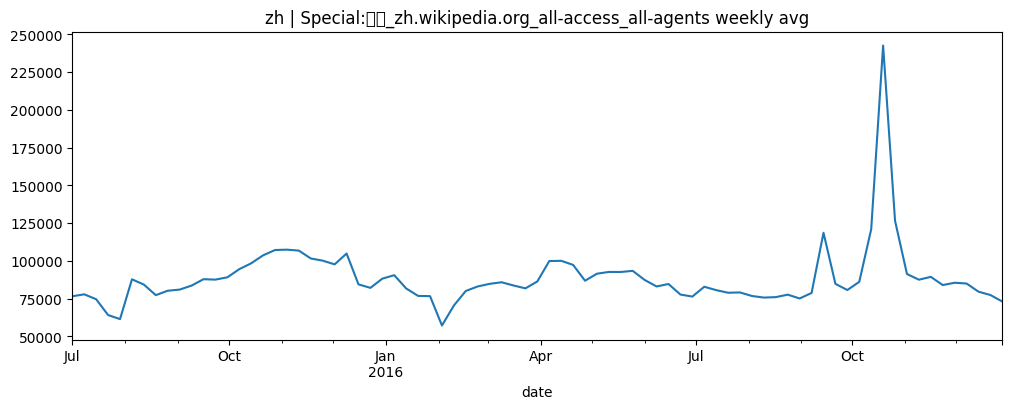

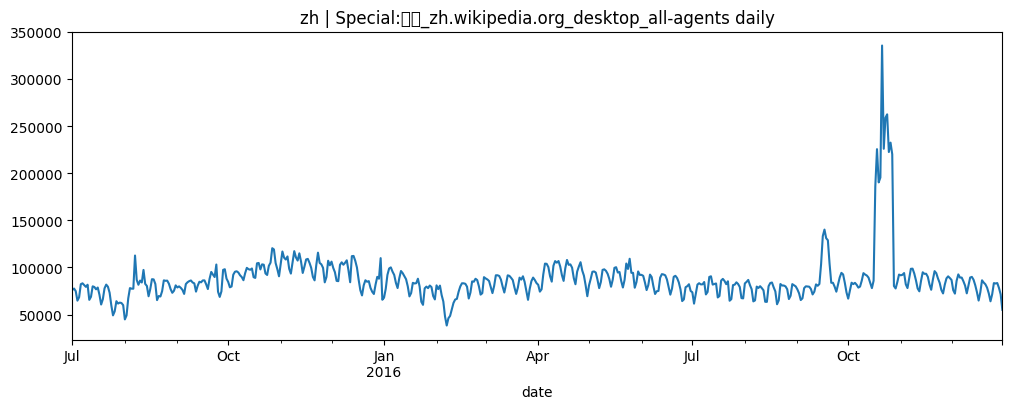

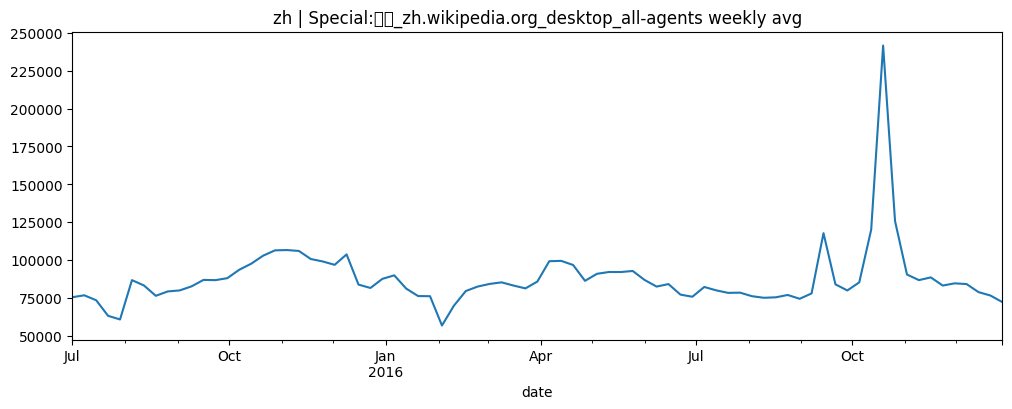


===== Language: ru =====
Top pages: ['Служебная:Поиск_ru.wikipedia.org_all-access_all-agents', 'Служебная:Поиск_ru.wikipedia.org_desktop_all-agents', 'Special:Search_ru.wikipedia.org_all-access_all-agents', 'Special:Search_ru.wikipedia.org_desktop_all-agents', 'Служебная:Вход_ru.wikipedia.org_all-access_all-agents']


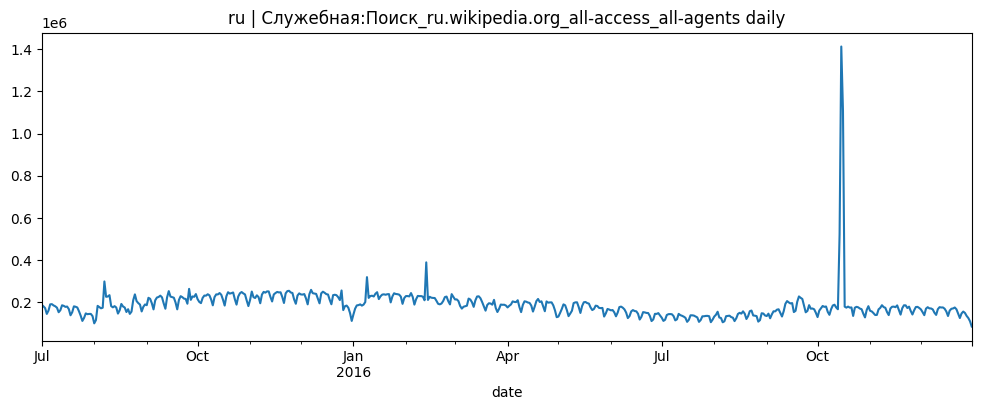

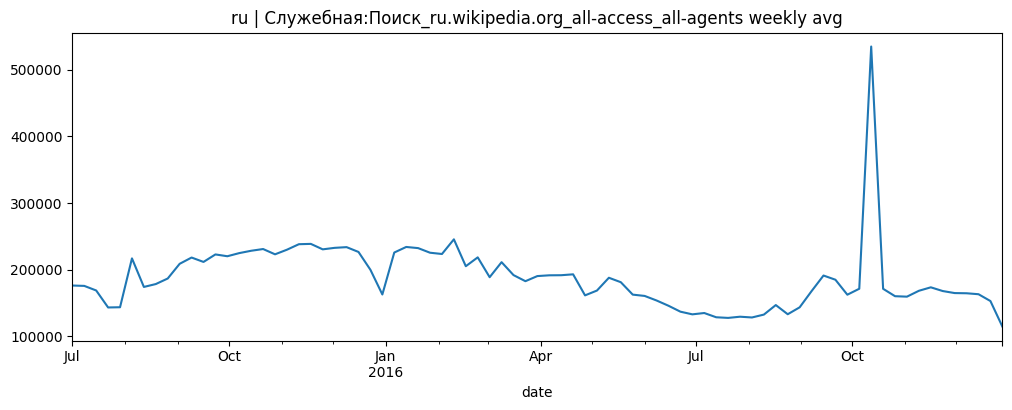

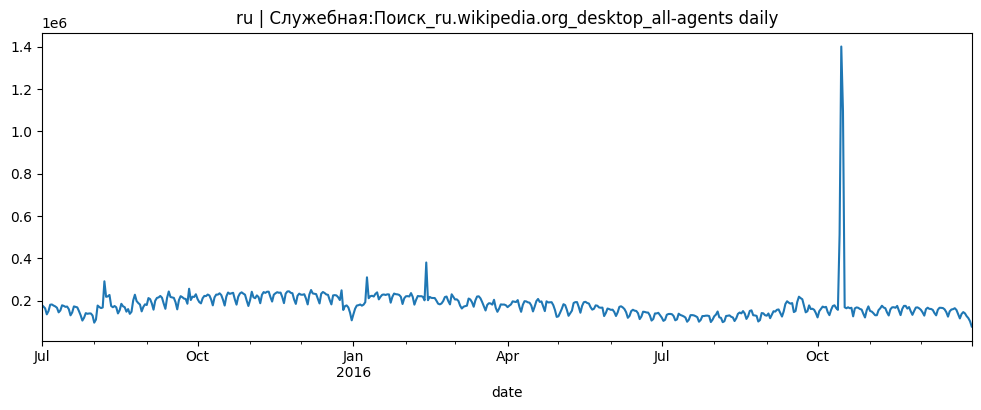

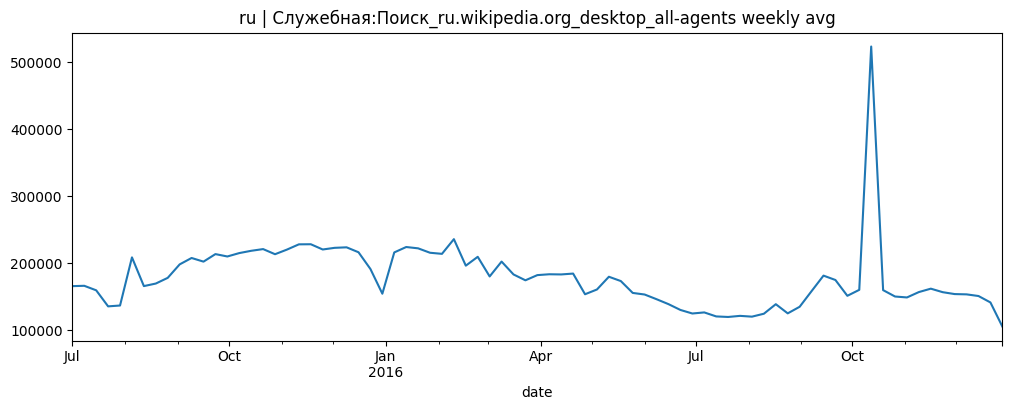

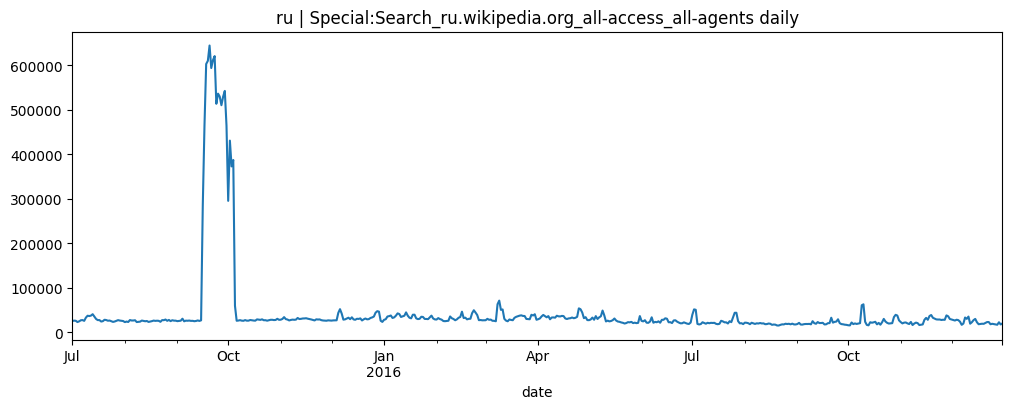

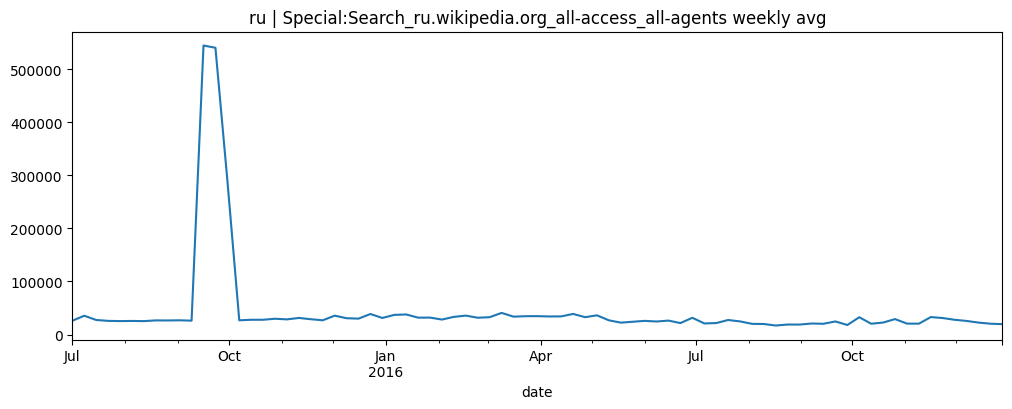

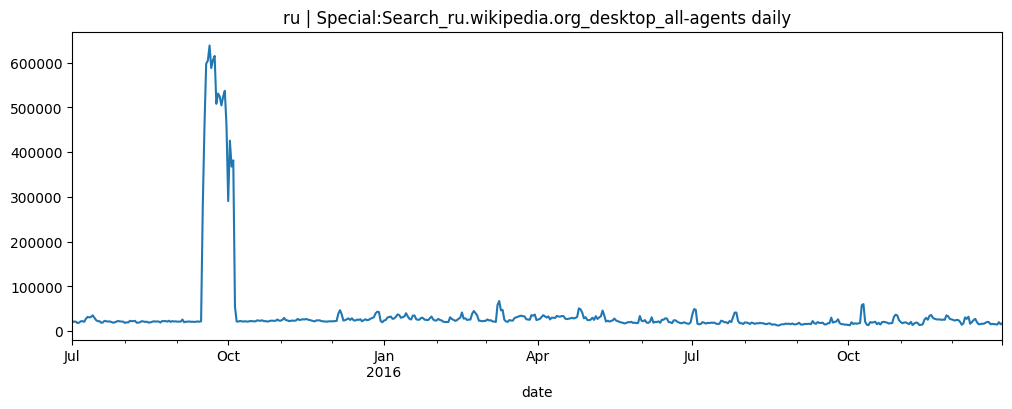

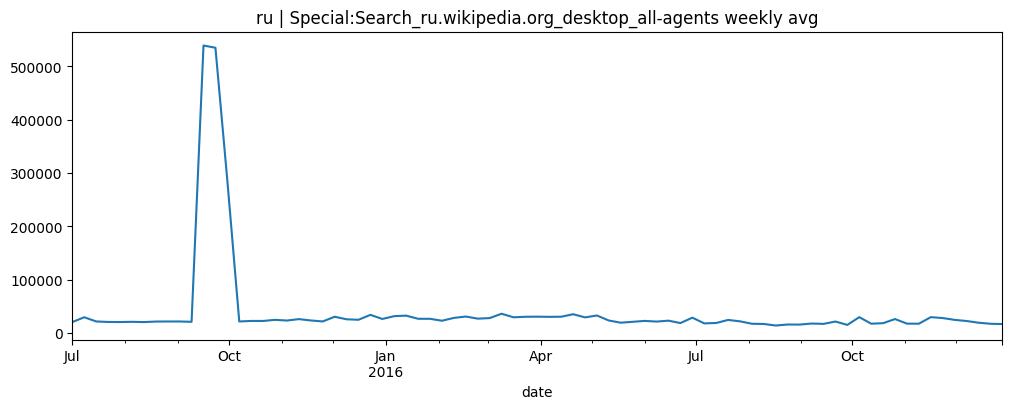

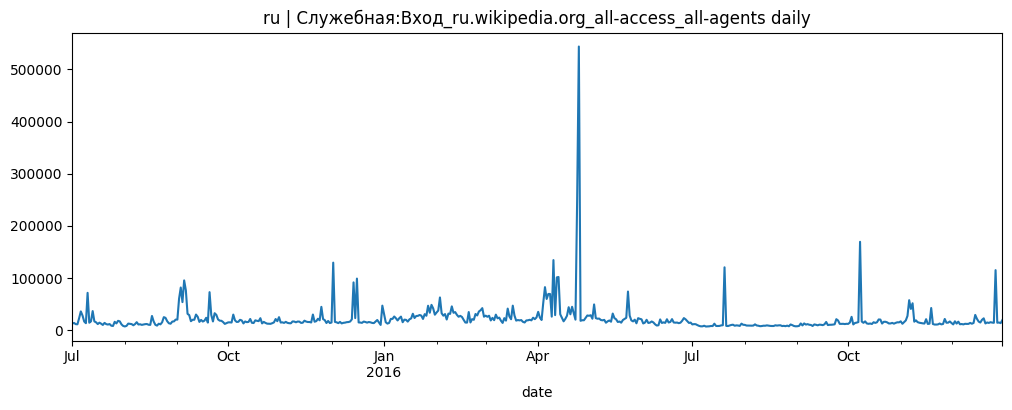

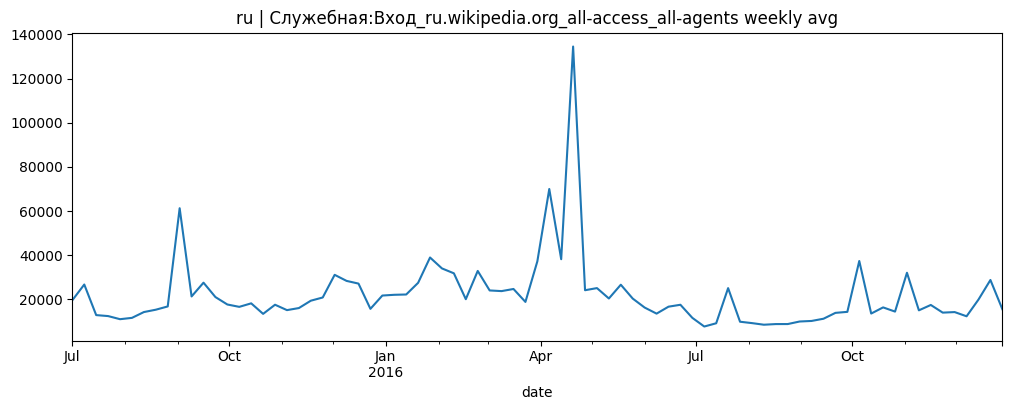


===== Language: de =====
Top pages: ['Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents', 'Wikipedia:Hauptseite_de.wikipedia.org_mobile-web_all-agents', 'Wikipedia:Hauptseite_de.wikipedia.org_desktop_all-agents', 'Spezial:Suche_de.wikipedia.org_all-access_all-agents', 'Spezial:Suche_de.wikipedia.org_desktop_all-agents']


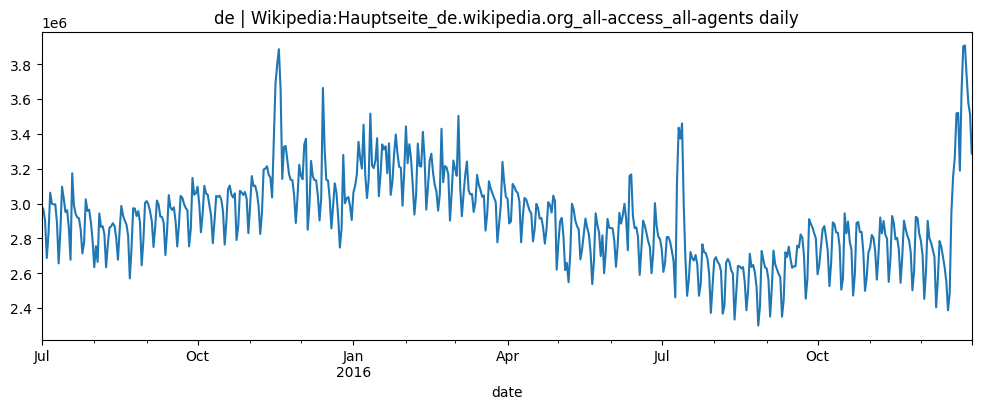

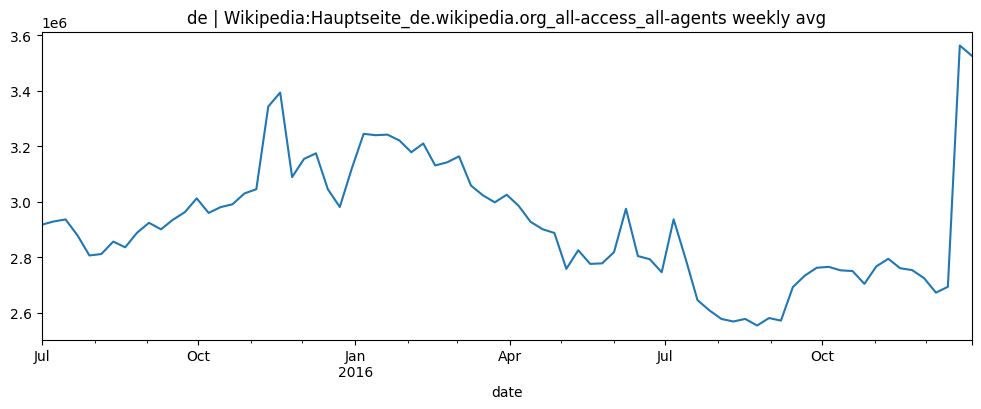

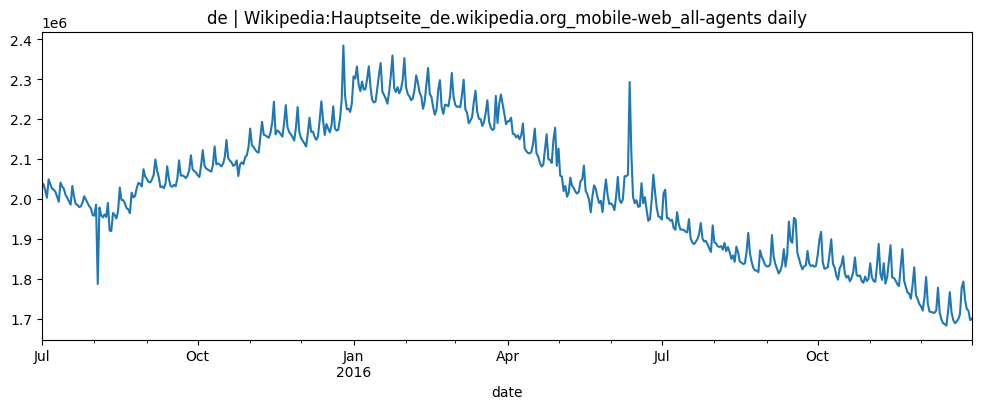

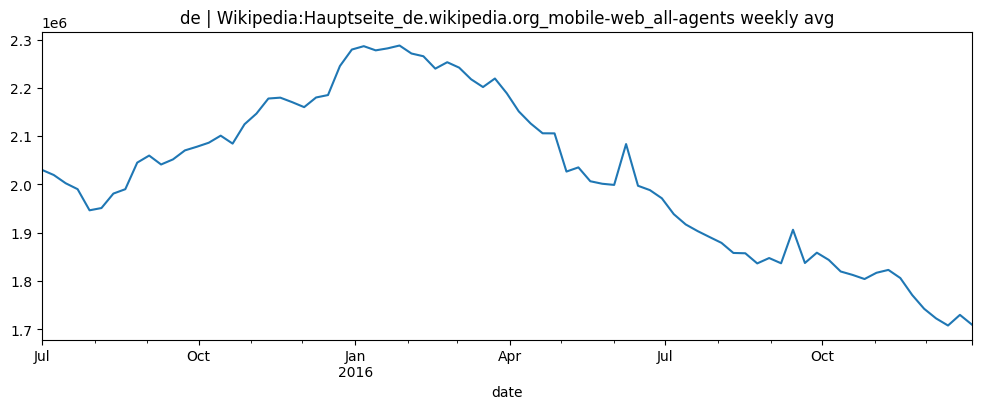

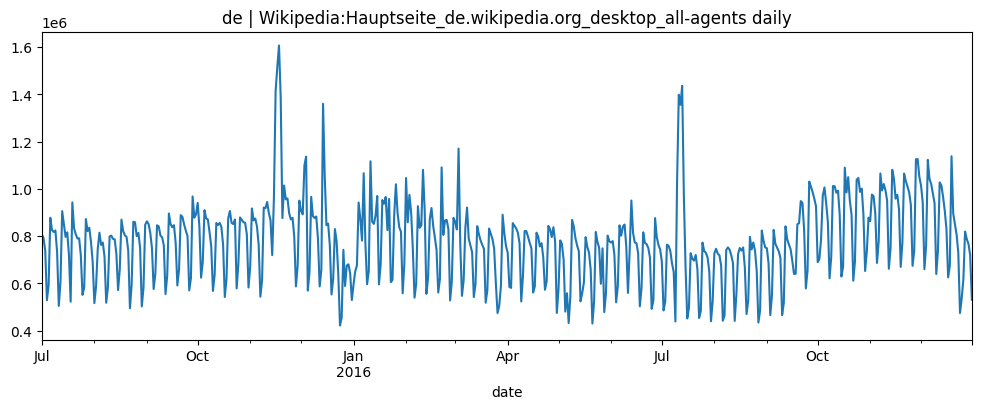

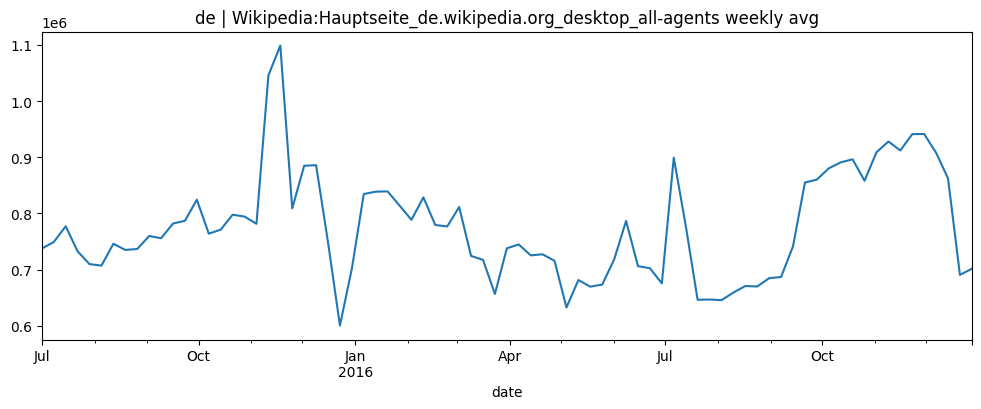

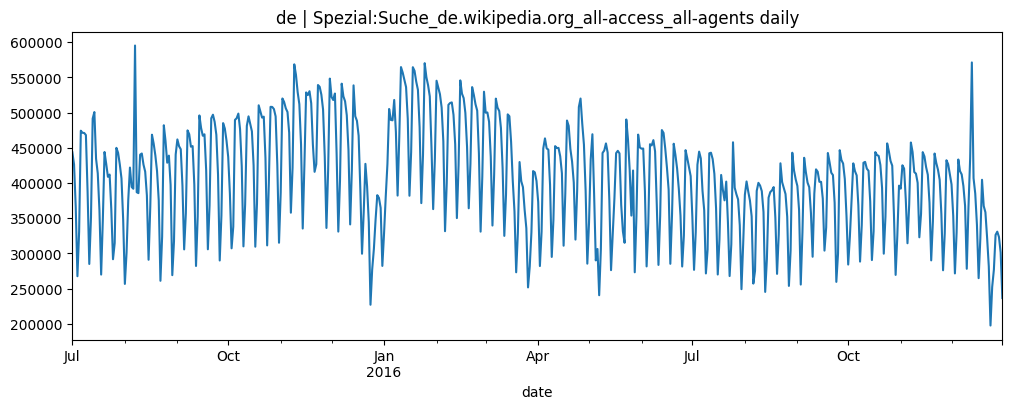

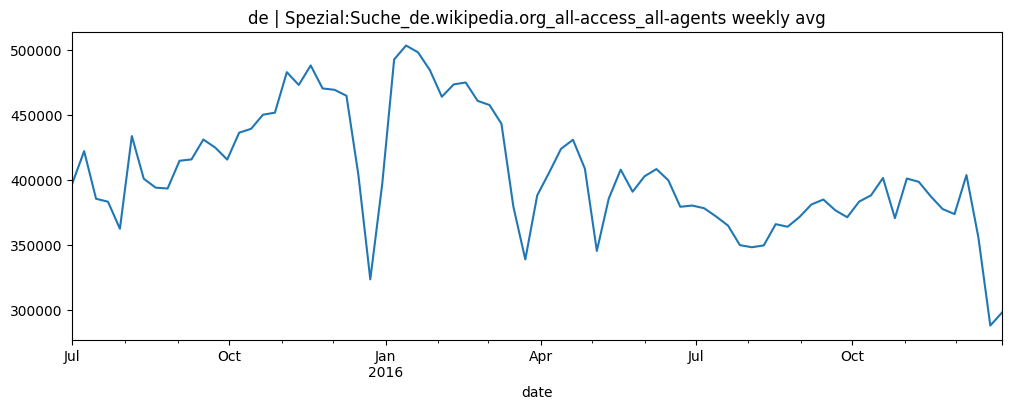

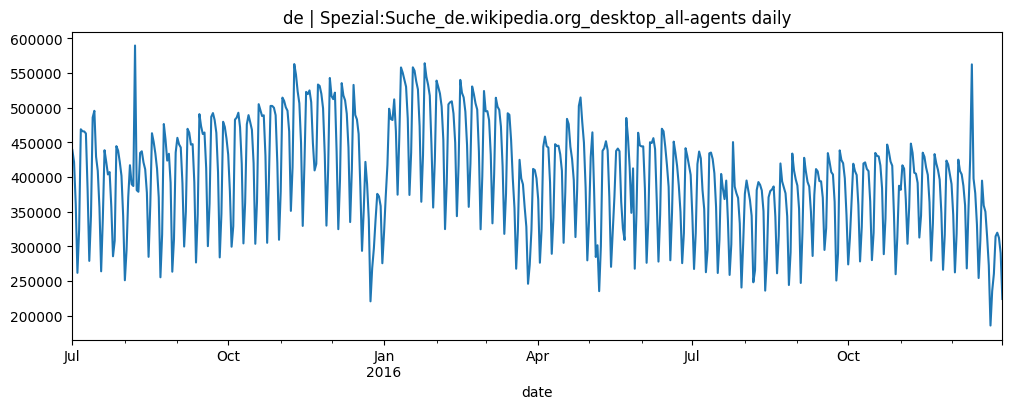

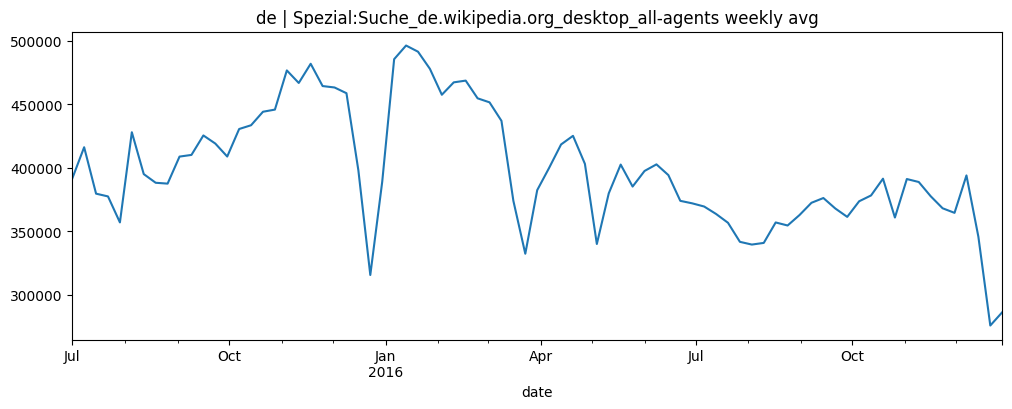


===== Language: ja =====
Top pages: ['メインページ_ja.wikipedia.org_all-access_all-agents', 'メインページ_ja.wikipedia.org_desktop_all-agents', '特別:検索_ja.wikipedia.org_all-access_all-agents', '特別:検索_ja.wikipedia.org_desktop_all-agents', 'メインページ_ja.wikipedia.org_mobile-web_all-agents']


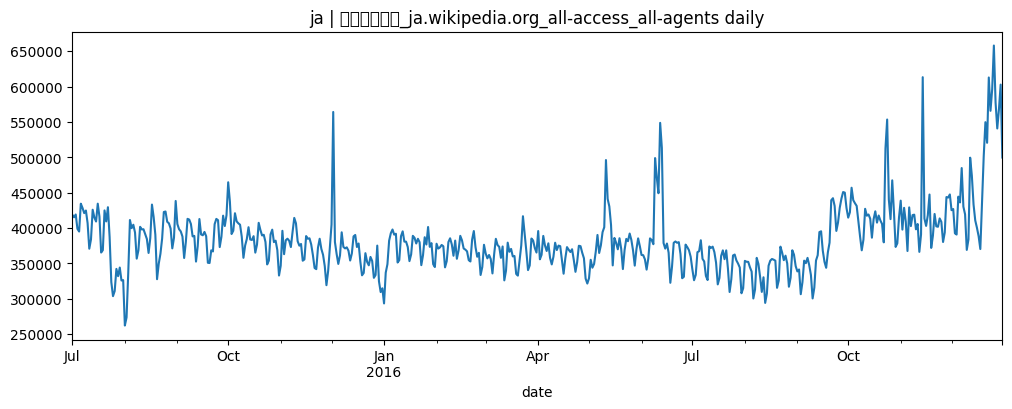

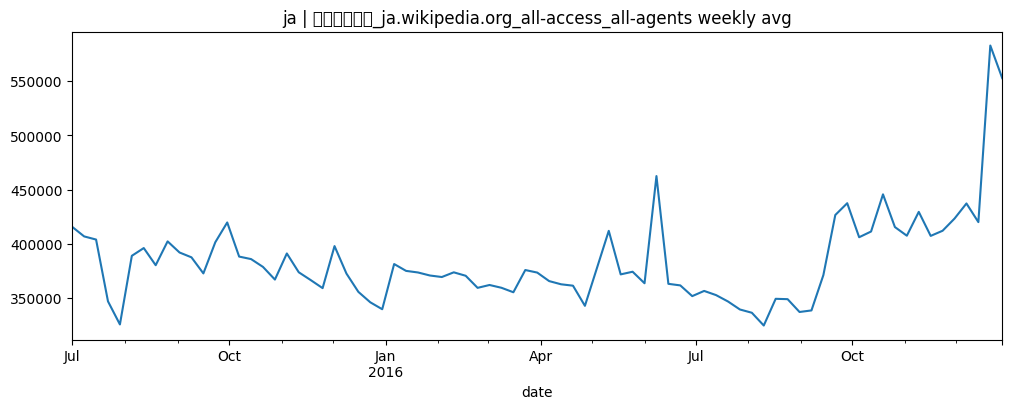

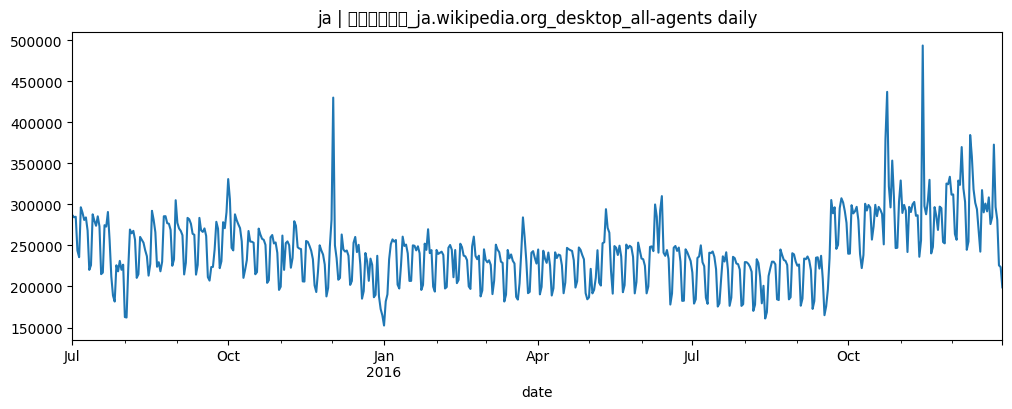

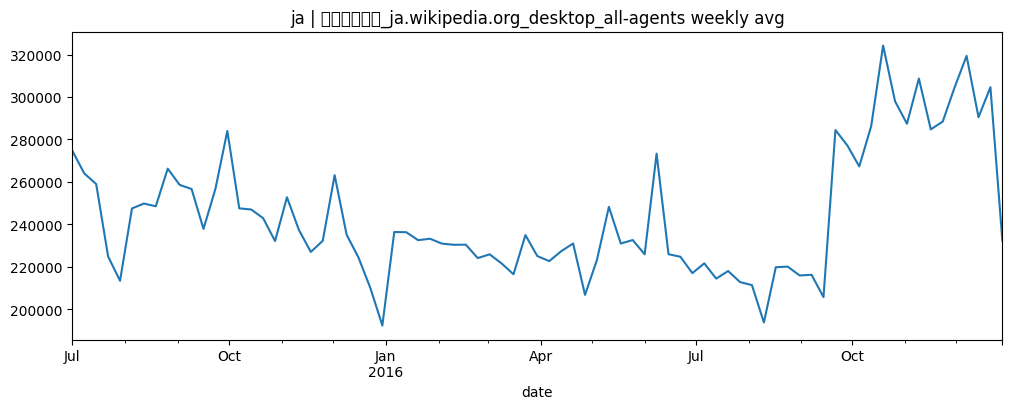

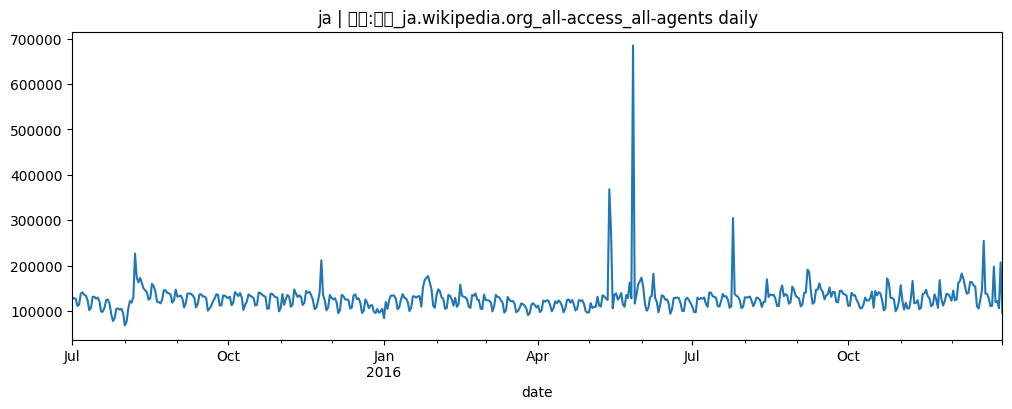

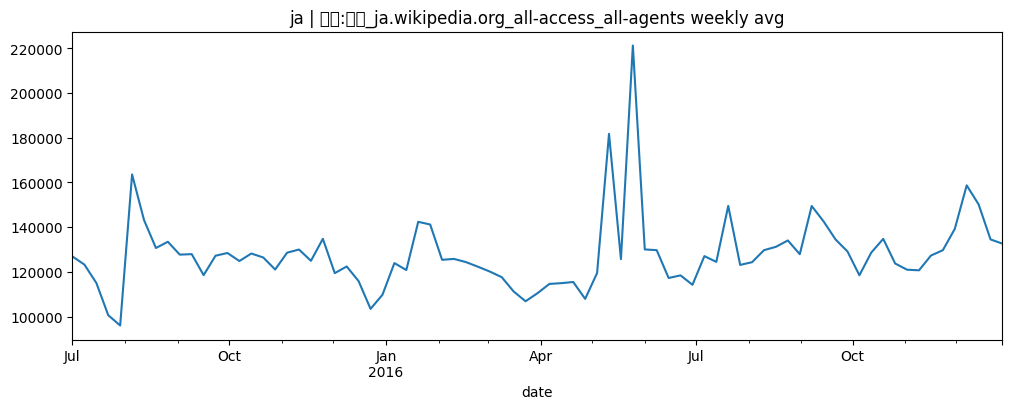

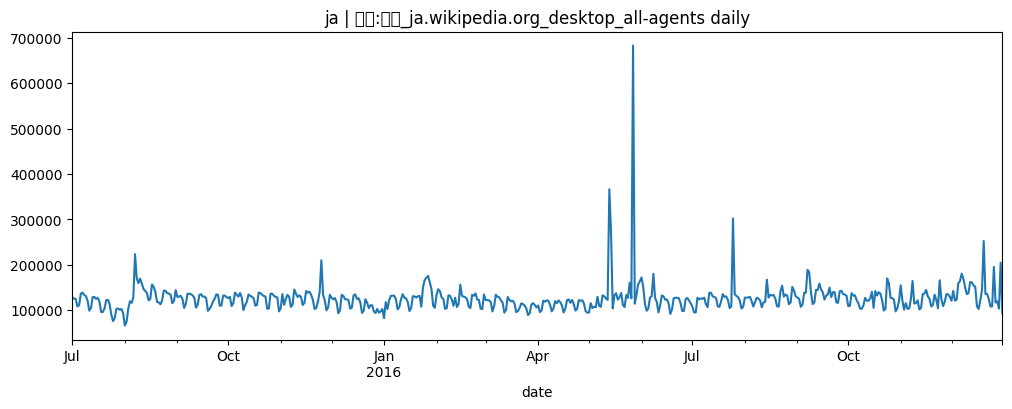

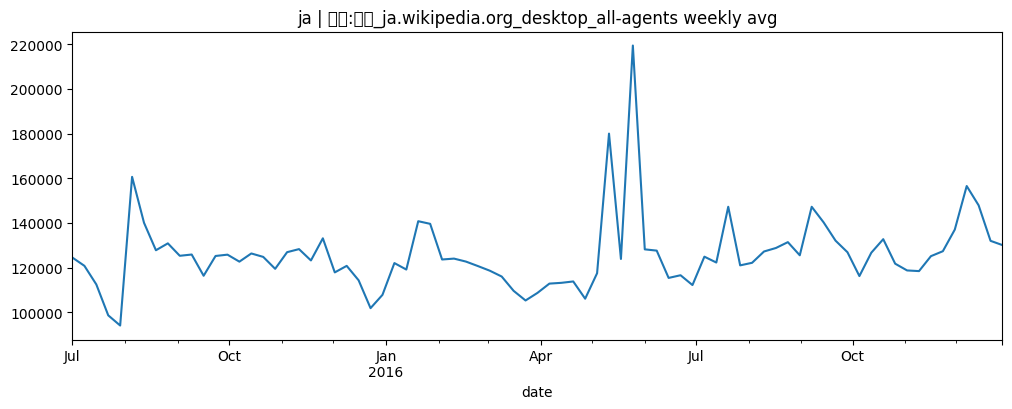

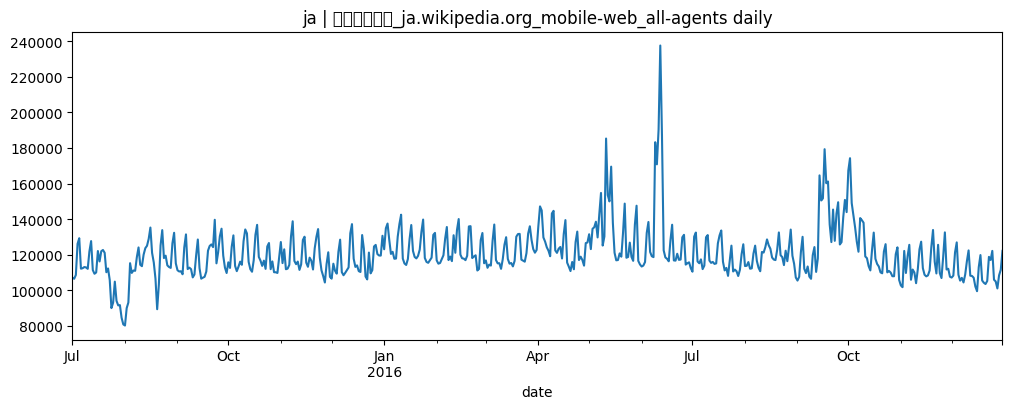

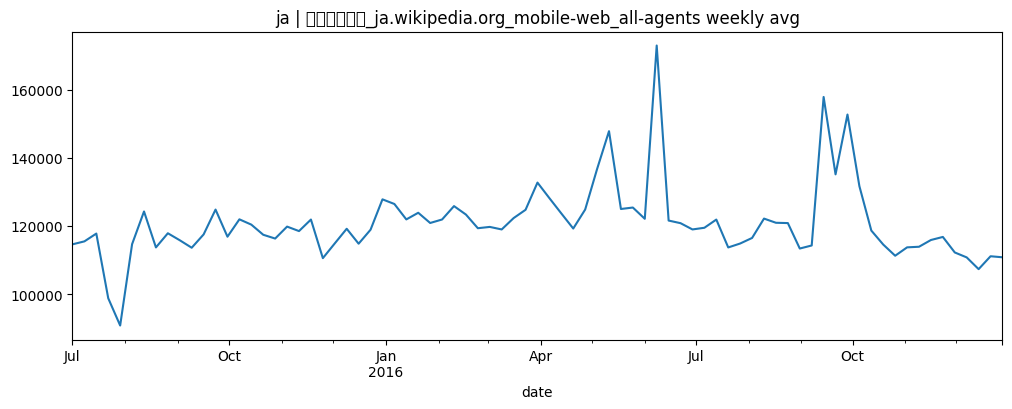


===== Language: es =====
Top pages: ['Wikipedia:Portada_es.wikipedia.org_all-access_all-agents', 'Wikipedia:Portada_es.wikipedia.org_mobile-web_all-agents', 'Especial:Buscar_es.wikipedia.org_all-access_all-agents', 'Wikipedia:Portada_es.wikipedia.org_desktop_all-agents', 'Especial:Buscar_es.wikipedia.org_desktop_all-agents']


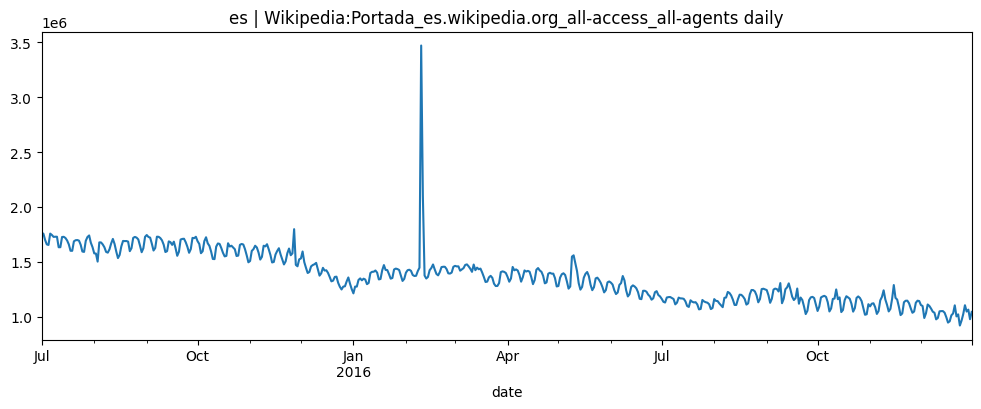

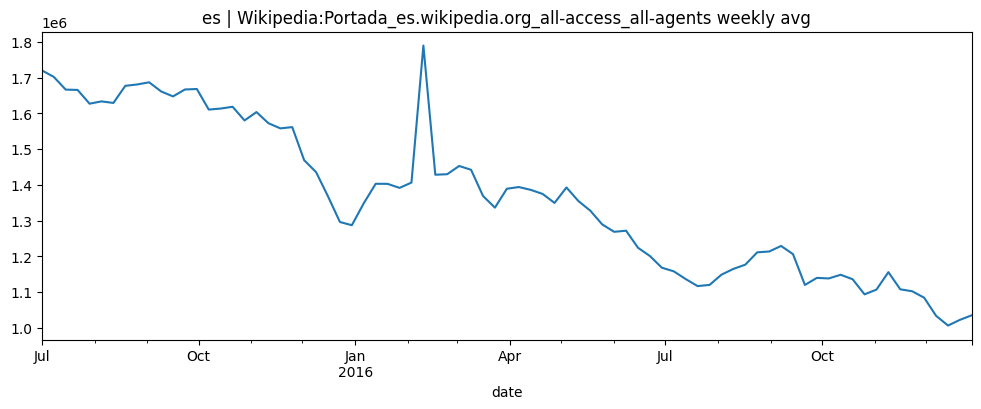

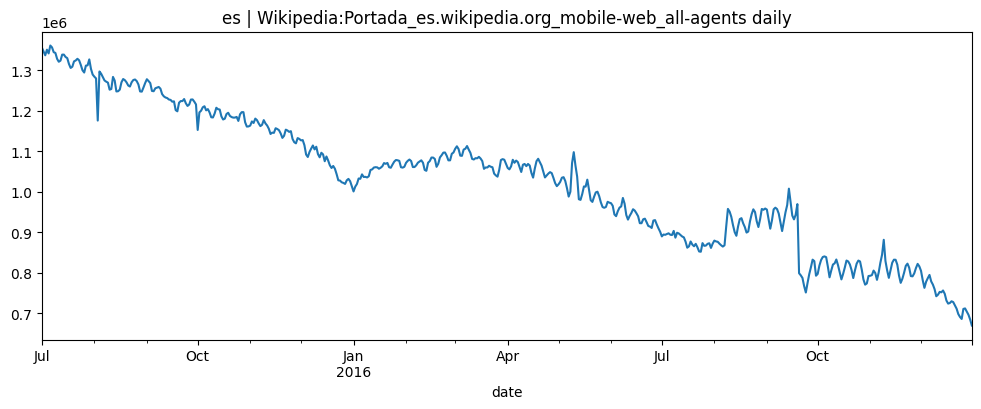

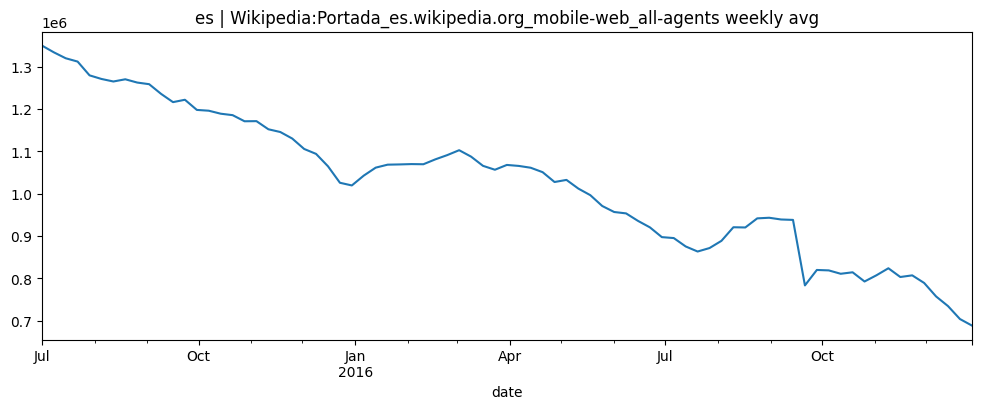

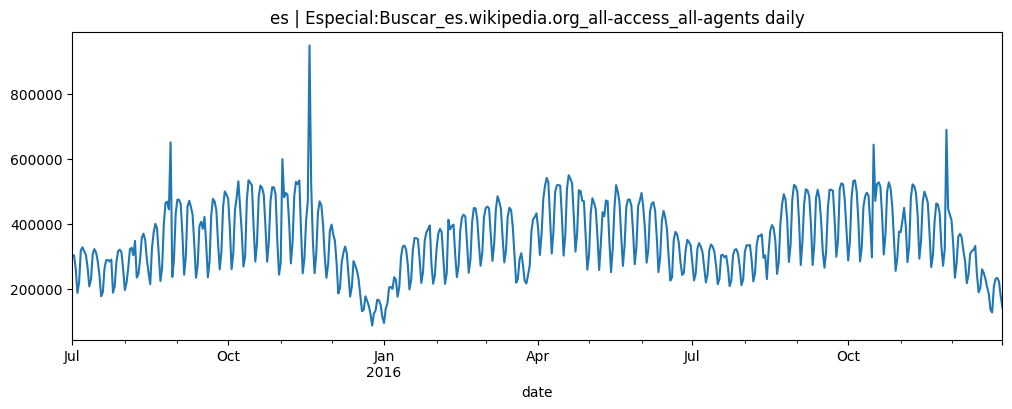

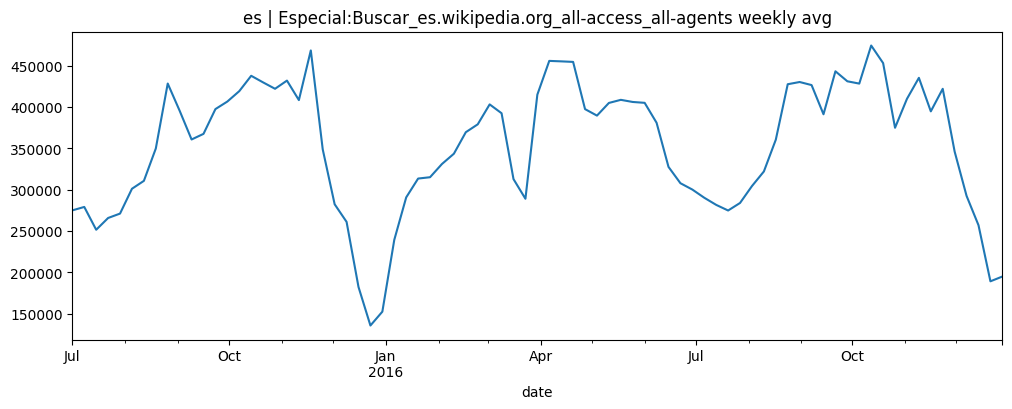

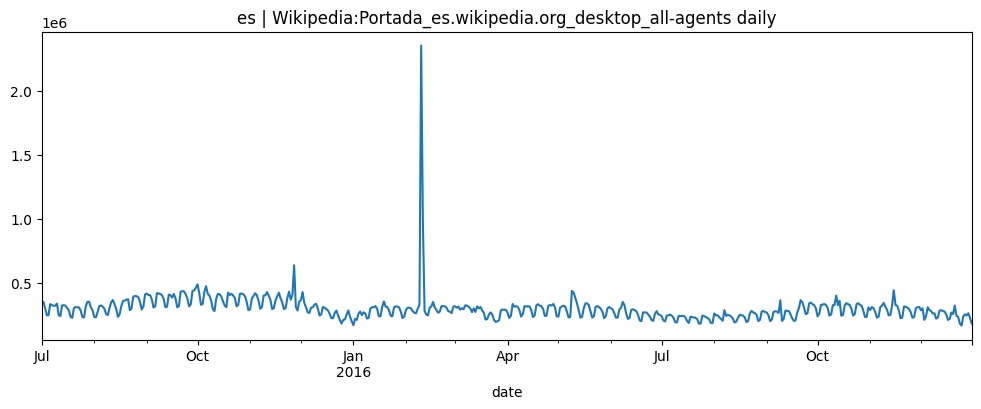

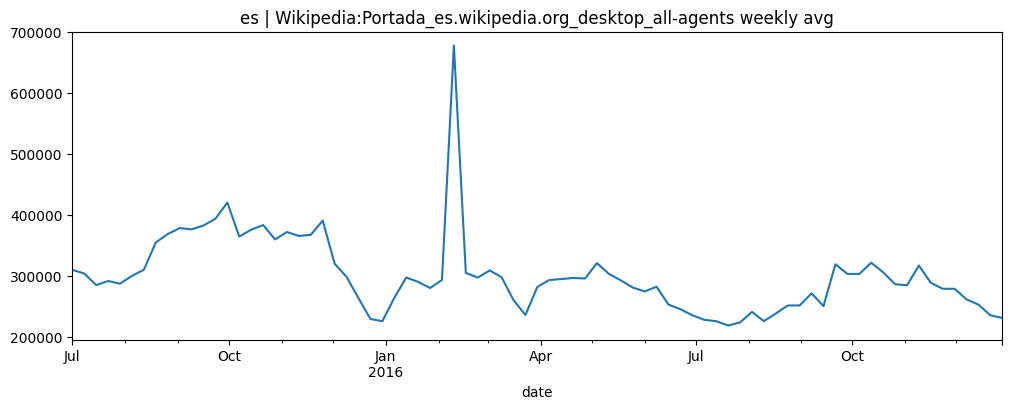

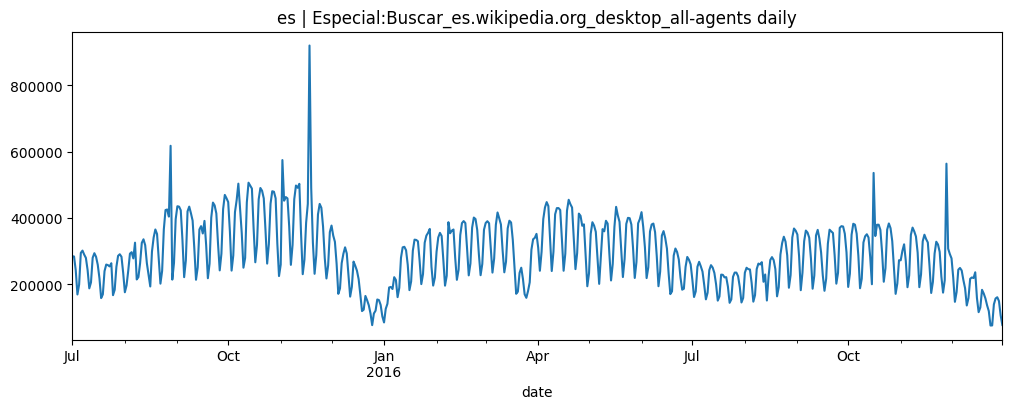

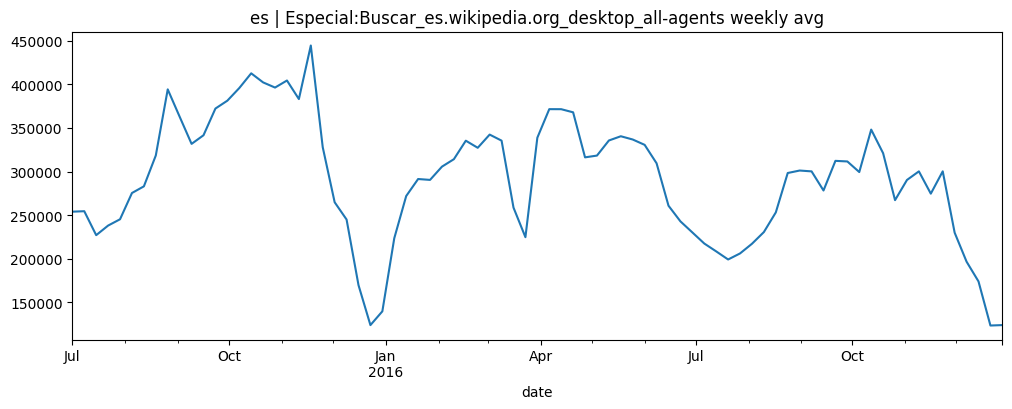

In [59]:
# Call function for each lang
for lang, dfs in lang_dfs.items():
    analyze_language_pages(
        lang=lang,
        dfs=dfs,
        top_n=5
    )


In [62]:
# Clean pages without null and duplicate
def clean_pages_no_nulls(df):
    return (
        df
        .drop_duplicates()
        .assign(_has_null=df.isna().any(axis=1))
        .groupby('page', group_keys=False)
        .filter(lambda g: not g['_has_null'].any())
        .drop(columns='_has_null')
    )
clean_ts = {}

for lang in final_ts.keys():
    clean_ts[lang] = clean_pages_no_nulls(final_ts[lang])


In [63]:
for lang, df in clean_ts.items():
    print(lang, "null rows:", df.isna().any(axis=1).sum())


en null rows: 0
fr null rows: 0
zh null rows: 0
ru null rows: 0
de null rows: 0
ja null rows: 0
es null rows: 0


In [64]:
{lang: df['page'].nunique() for lang, df in clean_ts.items()}


{'en': 1871,
 'fr': 2445,
 'zh': 12005,
 'ru': 2798,
 'de': 4290,
 'ja': 16488,
 'es': 3421}

In [69]:
## how many pages per language
TOP_PAGES = {
    'en': 300,
    'fr': 300,
    'zh': 700,
    'ru': 300,
    'de': 400,
    'ja': 800,
    'es': 300
}


In [70]:
## Function to get top pages for ONE language
def get_top_pages(df, n):
    return (
        df.groupby('page')['views']
        .sum()
        .sort_values(ascending=False)
        .head(n)
        .index
        .tolist()
    )


In [71]:
## Apply to ALL languages
top_pages_by_lang = {}

for lang, df in clean_ts.items():
    n = TOP_PAGES.get(lang, 300)   # default fallback
    top_pages_by_lang[lang] = get_top_pages(df, n)


In [72]:
## Example usage
top_pages_by_lang['en'][:10]


['Special:Search_en.wikipedia.org_all-access_all-agents',
 'Special:Search_en.wikipedia.org_desktop_all-agents',
 'Special:Search_en.wikipedia.org_mobile-web_all-agents',
 'Special:Book_en.wikipedia.org_all-access_all-agents',
 'Special:Book_en.wikipedia.org_desktop_all-agents',
 'Special:Search_en.wikipedia.org_all-access_spider',
 'XHamster_en.wikipedia.org_all-access_all-agents',
 'XHamster_en.wikipedia.org_mobile-web_all-agents',
 'Special:RecentChanges_en.wikipedia.org_all-access_all-agents',
 'Special:RecentChanges_en.wikipedia.org_desktop_all-agents']

In [73]:
len(top_pages_by_lang['ja'])


800

In [74]:
## Filter DataFrames to top pages only
top_ts = {}

for lang, df in clean_ts.items():
    pages = set(top_pages_by_lang[lang])
    top_ts[lang] = df[df['page'].isin(pages)]


In [75]:
## Optional: Aggregate “other pages” (long tail)
other_ts = {}

for lang, df in clean_ts.items():
    top_pages = set(top_pages_by_lang[lang])

    other_ts[lang] = (
        df[~df['page'].isin(top_pages)]
        .groupby('date', as_index=False)['views']
        .sum()
        .assign(page='__OTHER__')
    )


In [76]:
## Sanity checks
{lang: df['page'].nunique() for lang, df in top_ts.items()}


{'en': 300, 'fr': 300, 'zh': 700, 'ru': 300, 'de': 400, 'ja': 800, 'es': 300}

In [77]:
{lang: df.head(3) for lang, df in top_ts.items()}


{'en':                                                page title  ...       date    views
 624720  .xxx_en.wikipedia.org_all-access_all-agents  .xxx  ... 2015-07-01  15408.0
 625439  .xxx_en.wikipedia.org_all-access_all-agents  .xxx  ... 2015-07-02  17375.0
 626158  .xxx_en.wikipedia.org_all-access_all-agents  .xxx  ... 2015-07-03  17334.0
 
 [3 rows x 7 columns],
 'fr':                                             page title  ...       date  views
 722700  @_fr.wikipedia.org_all-access_all-agents     @  ... 2015-07-01  300.0
 723344  @_fr.wikipedia.org_all-access_all-agents     @  ... 2015-07-02  420.0
 723988  @_fr.wikipedia.org_all-access_all-agents     @  ... 2015-07-03  427.0
 
 [3 rows x 7 columns],
 'zh':                                                  page  title  ...       date  views
 5196164  16個夏天_zh.wikipedia.org_all-access_all-agents  16個夏天  ... 2015-07-01  735.0
 5198150  16個夏天_zh.wikipedia.org_all-access_all-agents  16個夏天  ... 2015-07-02  787.0
 5200136  16個夏天_zh.wikipe

In [78]:
## Step 1: ADF test function (core)

from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    return {
        'adf_stat': result[0],
        'p_value': result[1],
        'is_stationary': result[1] < 0.05
    }


In [79]:
## Step 2: Stationarity check for ONE language
def stationarity_by_language(df):
    results = []

    for page, g in df.groupby('page'):
        s = (
            g.sort_values('date')
             .set_index('date')['views']
        )

        adf = adf_test(s)

        results.append({
            'page': page,
            'adf_stat': adf['adf_stat'],
            'p_value': adf['p_value'],
            'is_stationary': adf['is_stationary']
        })

    return pd.DataFrame(results)


In [80]:
## Step 3: Apply to ALL languages
stationarity_results = {}

for lang, df in top_ts.items():
    stationarity_results[lang] = stationarity_by_language(df)


In [81]:
## Step 4: Language-level summary (VERY IMPORTANT)
summary = []

for lang, res in stationarity_results.items():
    summary.append({
        'language': lang,
        'total_pages': len(res),
        'stationary_pages': res['is_stationary'].sum(),
        'non_stationary_pages': (~res['is_stationary']).sum(),
        'stationary_pct': round(res['is_stationary'].mean() * 100, 2)
    })

stationarity_summary = pd.DataFrame(summary)
stationarity_summary.sort_values('stationary_pct', ascending=False)


language  total_pages  stationary_pages  non_stationary_pages  stationary_pct
0       en          300               251                    49           83.67
4       de          400               312                    88           78.00
5       ja          800               606                   194           75.75
3       ru          300               220                    80           73.33
1       fr          300               214                    86           71.33
2       zh          700               465                   235           66.43
6       es          300               175                   125           58.33

In [82]:
## Step 5: Differencing (when NOT stationary)

##Step 1: Differencing function
def difference_series(series, d=1):
    return series.diff(d).dropna()



In [83]:
## Step 2: Identify non-stationary pages per language
stationarity_results[lang]  # page-wise ADF results

#Extract non-stationary pages:
non_stationary_pages = {
    lang: set(
        res.loc[~res['is_stationary'], 'page']
    )
    for lang, res in stationarity_results.items()
}



In [84]:
##Step 3: Apply differencing ONLY where needed
diff_ts = {}

for lang, df in top_ts.items():
    ns_pages = non_stationary_pages.get(lang, set())

    transformed = []

    for page, g in df.groupby('page'):
        g = g.sort_values('date')

        if page in ns_pages:
            # apply differencing
            s = difference_series(g['views'], d=1)

            g = (
                g.loc[g.index[1:]]   # align after diff
                .assign(views=s.values, diff_order=1)
            )
        else:
            # keep original
            g = g.assign(diff_order=0)

        transformed.append(g)

    diff_ts[lang] = pd.concat(transformed, ignore_index=True)


In [85]:
## Step 4: Verify correctness
# no missing values introduced by differencing
for lang, df in diff_ts.items():
    print(lang, df['views'].isna().sum())


en 0
fr 0
zh 0
ru 0
de 0
ja 0
es 0


In [86]:
## Step 5: Quick sanity check (counts)
for lang, df in diff_ts.items():
    print(lang, df['diff_order'].value_counts())


en diff_order
0    138050
1     26901
Name: count, dtype: int64
fr diff_order
0    117700
1     47214
Name: count, dtype: int64
zh diff_order
0    255750
1    129015
Name: count, dtype: int64
ru diff_order
0    121000
1     43920
Name: count, dtype: int64
de diff_order
0    171600
1     48312
Name: count, dtype: int64
ja diff_order
0    333300
1    106506
Name: count, dtype: int64
es diff_order
0    96250
1    68625
Name: count, dtype: int64


In [88]:
##Step 1: Run ADF on DIFFERENCED data
stationarity_results_diff = {}

for lang, df in diff_ts.items():
    res = []

    for page, g in df.groupby('page'):
        s = (
            g.sort_values('date')
             .set_index('date')['views']
        )

        adf = adf_test(s)

        res.append({
            'page': page,
            'adf_stat': adf['adf_stat'],
            'p_value': adf['p_value'],
            'is_stationary': adf['is_stationary']
        })

    stationarity_results_diff[lang] = pd.DataFrame(res)


In [89]:
## Step 2: Recompute NEW summary
summary_diff = []

for lang, res in stationarity_results_diff.items():
    summary_diff.append({
        'language': lang,
        'total_pages': len(res),
        'stationary_pages': res['is_stationary'].sum(),
        'non_stationary_pages': (~res['is_stationary']).sum(),
        'stationary_pct': round(res['is_stationary'].mean() * 100, 2)
    })

stationarity_summary_diff = pd.DataFrame(summary_diff)
stationarity_summary_diff


language  total_pages  stationary_pages  non_stationary_pages  stationary_pct
0       en          300               300                     0          100.00
1       fr          300               300                     0          100.00
2       zh          700               699                     1           99.86
3       ru          300               300                     0          100.00
4       de          400               399                     1           99.75
5       ja          800               800                     0          100.00
6       es          300               300                     0          100.00

In [90]:
df['diff_order']  # 0 or 1


0         0
1         0
2         0
3         0
4         0
         ..
164870    0
164871    0
164872    0
164873    0
164874    0
Name: diff_order, Length: 164875, dtype: int64

In [93]:
## Step 1: Extract remaining non-stationary pages
problem_pages = {
    lang: res.loc[~res['is_stationary'], 'page'].tolist()
    for lang, res in stationarity_results_diff.items()
}
problem_pages

{'en': [],
 'fr': [],
 'zh': ['刺客教條系列_zh.wikipedia.org_all-access_all-agents'],
 'ru': [],
 'de': ['Hauptseite_de.wikipedia.org_all-access_all-agents'],
 'ja': [],
 'es': []}

In [ ]:
'''# Multi-Language Time Series Forecasting Notebook

This notebook demonstrates an **end-to-end time series forecasting pipeline** using **synthetic data**, designed for:
- Multiple **languages**
- Multiple **pages per language**
- **Missing values**
- Classical models (**ARIMA / SARIMA / SARIMAX**)
- **Facebook Prophet** with cross-validation
- **Model comparison tables**

---

## 1. Imports & Global Settings
```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

import warnings
warnings.filterwarnings('ignore')
```

---

## 2. Generate Synthetic Multi‑Language Dataset

We simulate:
- 3 languages (en, fr, hi)
- 3 pages per language
- Daily data
- Weekly seasonality
- Random missing values

```python
def generate_synthetic_data():
    np.random.seed(42)
    dates = pd.date_range('2018-01-01', '2019-12-31', freq='D')
    langs = ['en', 'fr', 'hi']
    pages = ['Page_A', 'Page_B', 'Page_C']

    rows = []
    for lang in langs:
        for page in pages:
            base = np.random.randint(100, 500)
            noise = np.random.normal(0, 20, len(dates))
            season = 50 * np.sin(2 * np.pi * dates.dayofweek / 7)
            views = base + season + noise

            # introduce missing values
            mask = np.random.rand(len(views)) < 0.1
            views[mask] = np.nan

            tmp = pd.DataFrame({
                'date': dates,
                'page': f'{page}_{lang}_desktop_all-access',
                'views': views,
                'language': lang
            })
            rows.append(tmp)

    return pd.concat(rows, ignore_index=True)

raw_df = generate_synthetic_data()
raw_df.head()
```

---

## 3. Exploratory Analysis
```python
raw_df.info()
```

```python'''

raw_df.isna().mean() * 100


## 4. Parse Page Name
```python
def parse_page(df):
    parts = df['page'].str.rsplit('_', expand=True)
    df['title'] = parts[0]
    df['lang'] = parts[1]
    df['access'] = parts[2]
    df['origin'] = parts[3]
    return df

raw_df = parse_page(raw_df)
raw_df.head()
```

---

## 5. Prepare Time Series (One Page)
```python
def prepare_series(df, page):
    s = (
        df[df['page'] == page]
        .set_index('date')['views']
        .asfreq('D')
    )

    # Interpolation for missing
    s = s.interpolate(method='time')
    return s
```

---

## 6. Stationarity Checks

### ADF Test
```python
def adf_test(series):
    result = adfuller(series.dropna())
    return {
        'ADF Statistic': result[0],
        'p-value': result[1]
    }
```

### Decomposition
```python
def decompose_series(series):
    stl = STL(series, period=7)
    res = stl.fit()
    res.plot()
    plt.show()
```

---

## 7. Differencing + ACF / PACF
```python
def plot_acf_pacf(series, lags=30):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    plot_acf(series, lags=lags, ax=ax[0])
    plot_pacf(series, lags=lags, ax=ax[1])
    plt.show()
```

---

## 8. Train ARIMA / SARIMAX
```python
def train_arima(series, order=(1,1,1)):
    model = ARIMA(series, order=order)
    res = model.fit()
    return res
```

```python
def train_sarimax(series, order=(1,1,1), seasonal_order=(1,1,1,7), exog=None):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order, exog=exog)
    res = model.fit(disp=False)
    return res
```

---

## 9. Prophet Model + Cross‑Validation
```python
def train_prophet(series):
    dfp = series.reset_index()
    dfp.columns = ['ds', 'y']

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )
    m.fit(dfp)
    return m
```

```python
def prophet_cv(model, horizon='90 days'):
    cv = cross_validation(
        model,
        horizon=horizon,
        period='30 days',
        initial='365 days'
    )
    return performance_metrics(cv)
```

---

## 10. Model Comparison Metrics
```python
def evaluate(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred, squared=False)
    }
```

---

## 11. Full Pipeline for One Language
```python
def analyze_language(df, lang, top_n=2):
    df_lang = df[df['language'] == lang]

    # Top pages
    top_pages = (
        df_lang.groupby('page')['views']
        .sum()
        .sort_values(ascending=False)
        .head(top_n)
        .index.tolist()
    )

    results = []

    for page in top_pages:
        s = prepare_series(df_lang, page)

        train = s.iloc[:-90]
        test = s.iloc[-90:]

        # ARIMA
        arima = train_arima(train)
        arima_pred = arima.forecast(90)
        arima_metrics = evaluate(test, arima_pred)

        # SARIMAX
        sarimax = train_sarimax(train)
        sarimax_pred = sarimax.forecast(90)
        sarimax_metrics = evaluate(test, sarimax_pred)

        # Prophet
        prophet = train_prophet(train)
        future = prophet.make_future_dataframe(periods=90)
        forecast = prophet.predict(future)
        yhat = forecast.set_index('ds')['yhat'][-90:]
        prophet_metrics = evaluate(test, yhat)

        results.append({
            'language': lang,
            'page': page,
            'ARIMA_MAE': arima_metrics['MAE'],
            'SARIMAX_MAE': sarimax_metrics['MAE'],
            'Prophet_MAE': prophet_metrics['MAE']
        })

    return pd.DataFrame(results)
```

---

## 12. Run Pipeline for All Languages
```python
comparison = []
for lang in raw_df['language'].unique():
    res = analyze_language(raw_df, lang)
    comparison.append(res)

final_results = pd.concat(comparison, ignore_index=True)
final_results
```

---

## 13. Final Inference
```python
final_results.groupby('language').mean().sort_values('Prophet_MAE')
```

---

## What You Achieved
- Full multi‑language forecasting pipeline
- Missing data handling
- Stationarity diagnostics
- ARIMA / SARIMAX / Prophet
- Prophet cross‑validation
- Automated comparison table



In [ ]:
## 6. Stationarity Checks

### ADF Test
```python
def adf_test(series):
    result = adfuller(series.dropna())
    return {
        'ADF Statistic': result[0],
        'p-value': result[1]
    }

In [ ]:
### Decomposition
```python
def decompose_series(series):
    stl = STL(series, period=7)
    res = stl.fit()
    res.plot()
    plt.show()

In [ ]:
## 7. Differencing + ACF / PACF
```python
def plot_acf_pacf(series, lags=30):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    plot_acf(series, lags=lags, ax=ax[0])
    plot_pacf(series, lags=lags, ax=ax[1])
    plt.show()

In [ ]:
## 8. Train ARIMA / SARIMAX
```python
def train_arima(series, order=(1,1,1)):
    model = ARIMA(series, order=order)
    res = model.fit()
    return res

def train_sarimax(series, order=(1,1,1), seasonal_order=(1,1,1,7), exog=None):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order, exog=exog)
    res = model.fit(disp=False)
    return res

In [ ]:
## 9. Prophet Model + Cross‑Validation
```python
def train_prophet(series):
    dfp = series.reset_index()
    dfp.columns = ['ds', 'y']

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )
    m.fit(dfp)
    return m
```

```python
def prophet_cv(model, horizon='90 days'):
    cv = cross_validation(
        model,
        horizon=horizon,
        period='30 days',
        initial='365 days'
    )
    return performance_metrics(cv)

In [ ]:
## 10. Model Comparison Metrics
```python
def evaluate(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred, squared=False)
    }

In [ ]:
## 11. Full Pipeline for One Language
```python
def analyze_language(df, lang, top_n=2):
    df_lang = df[df['language'] == lang]

    # Top pages
    top_pages = (
        df_lang.groupby('page')['views']
        .sum()
        .sort_values(ascending=False)
        .head(top_n)
        .index.tolist()
    )

    results = []

    for page in top_pages:
        s = prepare_series(df_lang, page)

        train = s.iloc[:-90]
        test = s.iloc[-90:]

        # ARIMA
        arima = train_arima(train)
        arima_pred = arima.forecast(90)
        arima_metrics = evaluate(test, arima_pred)

        # SARIMAX
        sarimax = train_sarimax(train)
        sarimax_pred = sarimax.forecast(90)
        sarimax_metrics = evaluate(test, sarimax_pred)

        # Prophet
        prophet = train_prophet(train)
        future = prophet.make_future_dataframe(periods=90)
        forecast = prophet.predict(future)
        yhat = forecast.set_index('ds')['yhat'][-90:]
        prophet_metrics = evaluate(test, yhat)

        results.append({
            'language': lang,
            'page': page,
            'ARIMA_MAE': arima_metrics['MAE'],
            'SARIMAX_MAE': sarimax_metrics['MAE'],
            'Prophet_MAE': prophet_metrics['MAE']
        })

    return pd.DataFrame(results)

In [ ]:
## 12. Run Pipeline for All Languages
```python
comparison = []
for lang in raw_df['language'].unique():
    res = analyze_language(raw_df, lang)
    comparison.append(res)

final_results = pd.concat(comparison, ignore_index=True)
final_results

In [ ]:
## 13. Final Inference
```python
final_results.groupby('language').mean().sort_values('Prophet_MAE')

In [2]:
## What You Achieved
'''- Full multi‑language forecasting pipeline
- Missing data handling
- Stationarity diagnostics
- ARIMA / SARIMAX / Prophet
- Prophet cross‑validation
- Automated comparison table'''

'- Full multi‑language forecasting pipeline\n- Missing data handling\n- Stationarity diagnostics\n- ARIMA / SARIMAX / Prophet\n- Prophet cross‑validation\n- Automated comparison table'

#Stationarity & decomposition utilities

In [ ]:
def adf_test(series):
    series = series.dropna()
    if len(series) < 12:
        return {"adf":np.nan,"pval":np.nan}
    res = adfuller(series, autolag='AIC')
    return {"adf":res[0], "pval":res[1]}

def decompose_plot(series, period=7, model='additive'):
    series = series.dropna()
    dec = seasonal_decompose(series, model=model, period=period)
    fig = dec.plot()
    fig.set_size_inches(10,6)
    plt.show()


#ACF/PACF quick plots

In [ ]:
def plot_acf_pacf(series, lags=40):
    fig, axes = plt.subplots(1,2,figsize=(14,4))
    plot_acf(series.dropna(), ax=axes[0], lags=lags)
    plot_pacf(series.dropna(), ax=axes[1], lags=lags, method='ywm')
    plt.show()


#auto_arima -> SARIMAX wrapper for one series (with optional exog)

In [ ]:
def fit_auto_arima_and_sarimax(series, exog=None, seasonal_m=7, max_p=3, max_q=3, stepwise=True, n_periods=30):
    # series: pandas Series indexed by date (datetime)
    # exog: pandas DataFrame aligned to series index (same length)
    # returns the fitted SARIMAX result and auto_arima object
    series = series.dropna()

    auto = pm.auto_arima(series, seasonal=True, m=seasonal_m,
                         max_p=max_p, max_q=max_q, max_P=2, max_Q=2, stepwise=stepwise,
                         error_action='ignore', suppress_warnings=True, trace=False)
    order = auto.order
    seasonal_order = auto.seasonal_order

    # Build SARIMAX on original series (statsmodels)
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order, exog=exog, enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    # forecast
    if exog is None:
        fc = res.get_forecast(steps=n_periods)
        return res, auto, fc
    else:
        # if exog future values not available, assume zeros or last known
        # here we will simply forecast in-sample or need external future exog
        fc = res.get_forecast(steps=n_periods, exog=None)
        return res, auto, fc


#Prophet wrapper

In [ ]:
def fit_prophet(series, exog=None, periods=30, weekly_seasonality=True, daily_seasonality=False):
    df = series.reset_index().rename(columns={'date':'ds','views':'y'})
    # if exog has columns, merge them into df (align by ds)
    m = Prophet(daily_seasonality=daily_seasonality, weekly_seasonality=weekly_seasonality)
    if exog is not None:
        for col in exog.columns:
            m.add_regressor(col)
        df = df.merge(exog.reset_index().rename(columns={'index':'ds'}), on='ds', how='left')
    m.fit(df)
    future = m.make_future_dataframe(periods=periods)
    # merge future exog if available (not implemented here)
    forecast = m.predict(future)
    return m, forecast


#Full workflow for a single page (English)

ADF: {'adf': np.float64(-11.076045869136758), 'pval': np.float64(4.4299835684435036e-20)}


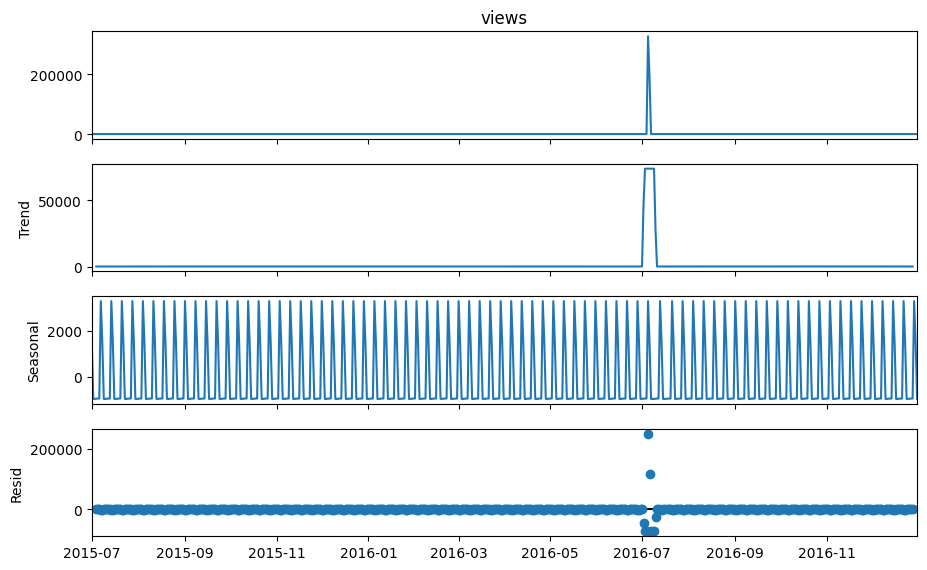

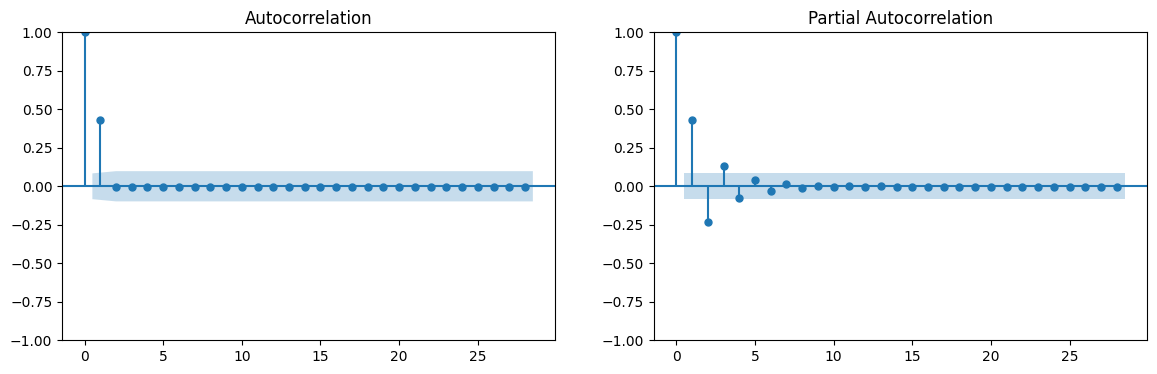

SARIMAX forecast sample: 548    2.83189
549    0.00000
550    0.00000
551    0.00000
552    0.00000
Name: predicted_mean, dtype: float64


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


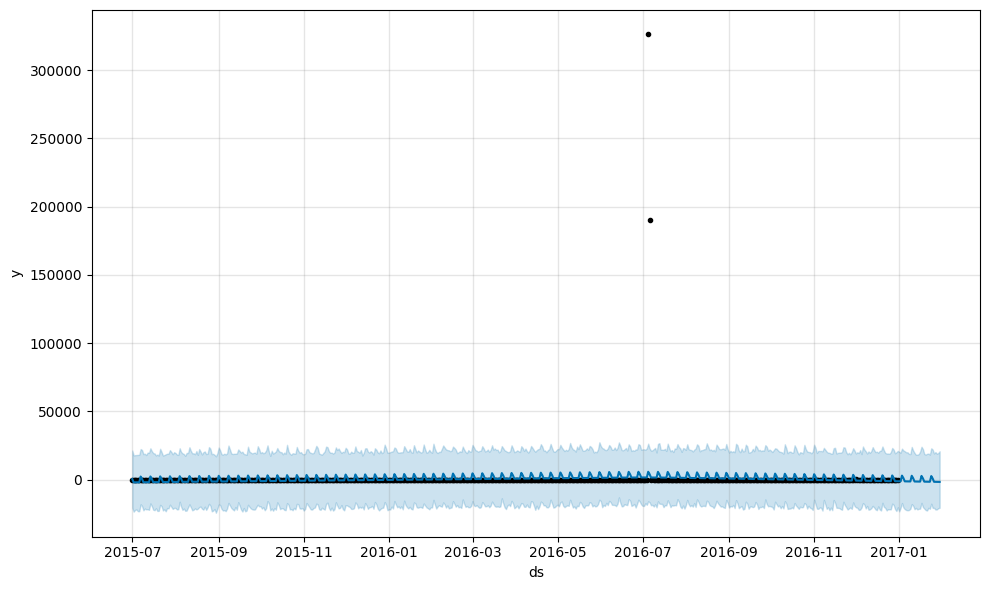

In [ ]:
# pick a page
page = ts_en['page'].value_counts().index[0]  # or choose a page name
s = ts_en[ts_en['page']==page].set_index('date')['views'].rename("views")
s = s.sort_index()

# ADF
print("ADF:", adf_test(s))

# decompose
decompose_plot(s, period=7)

# ACF/PACF
plot_acf_pacf(s, lags=28)

# auto_arima + SARIMAX
# if english and exog exists, create exog aligned with s index
if os.path.exists('exog'):
    exog_df = pd.read_csv(EXOG_PATH, parse_dates=True)  # adjust reading logic to file structure
    # exog_df should be a single-row or single-column with dates as columns or as rows; transform appropriately
else:
    exog_df = None

res, auto, fc = fit_auto_arima_and_sarimax(s, exog=None, seasonal_m=7, n_periods=30)
pred = fc.predicted_mean
print("SARIMAX forecast sample:", pred[:5])

# Prophet
m, fcast = fit_prophet(s.reset_index().rename(columns={'date':'ds','views':'y'}), exog=None, periods=30)
m.plot(fcast); plt.show()


#Evaluate forecast (example with holdout)

In [ ]:
# make a simple holdout for last 28 days
train_len = int(len(s)*0.9)
train_s = s.iloc[:train_len]
test_s = s.iloc[train_len:]

res, auto, fc_in = fit_auto_arima_and_sarimax(train_s, exog=None, seasonal_m=7, n_periods=len(test_s))
yhat = fc_in.predicted_mean
print("MAPE SARIMAX:", mape(test_s.values, yhat.values))

# Prophet
m, fcast = fit_prophet(train_s.reset_index().rename(columns={'date':'ds','views':'y'}), exog=None, periods=len(test_s))
yhat_p = fcast['yhat'].iloc[-len(test_s):].values
print("MAPE Prophet:", mape(test_s.values, yhat_p))


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE SARIMAX: 99.7357593542335
MAPE Prophet: 10234.614639943673


#Convert wide -> long (tidy time series)

In [ ]:
TRAIN_PATH = '/content/drive/Copy of train_1.cs'
EXOG_PATH = '/content/drive/Copy of Exog_Campaign_eng'

train = pd.read_csv(TRAIN_PATH, low_memory=False)
exog = pd.read_csv(EXOG_PATH, parse_dates=True)   # likely columns are dates and 0/1 flags

print(train.shape)
train.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Copy of train_1.cs'

In [ ]:
date_cols = [c for c in train.columns if c.startswith('20')]

ts = train.melt(
    id_vars=['page','title','language','access_type','access_origin'],
    value_vars=date_cols
)

SchemaFieldNotFoundError: page

In [ ]:
# Assume date columns start at column index after the parsed fields. Adjust accordingly.
date_cols = [c for c in train.columns if c.startswith('20')]  # e.g., '2015-07-01' style
# melt to long
ts = train.melt(id_vars=['page','title','language','access_type','access_origin'],
                value_vars=date_cols,
                var_name='date', value_name='views')
ts['date'] = pd.to_datetime(ts['date'])
ts = ts.sort_values(['page','date'])
ts.head()


In [ ]:
df1.shape, df2.shape

((145063, 551), (550, 1))

In [ ]:
train = pl.read_csv(
    "Copy of train_1.csv",
    schema_overrides="utf8",      # read EVERYTHING as string
    ignore_errors=True
)


TypeError: argument 'overwrite_dtype_slice': Can't extract `str` to `Vec`

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Exog    550 non-null    int64
dtypes: int64(1)
memory usage: 4.4 KB


In [ ]:
df1.columns

Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
       '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=551)

In [ ]:
df1.dtypes

Page           object
2015-07-01    float64
2015-07-02    float64
2015-07-03    float64
2015-07-04    float64
               ...   
2016-12-27    float64
2016-12-28    float64
2016-12-29    float64
2016-12-30    float64
2016-12-31    float64
Length: 551, dtype: object

In [ ]:
df1.dtypes[df1.dtypes != 'float64']

Page    object
dtype: object

#Importing the dataset and doing usual exploratory analysis steps like checking the structure & characteristics of the dataset (10 points)

In [ ]:
#Importing the dataset and doing usual exploratory analysis steps like checking the structure & characteristics of the dataset (10 points)

#null values check
df1.isna().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64